In [1]:
import os
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from models import TrajectoryGraph, initialize_trajectory


/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellrank/lib/python3.12/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/work/vanaja_lab/griffin/miniconda3/envs/cellr

In [2]:
adata = sc.read('data/mouse_panc_dev.h5ad')

In [3]:
# Build the trajectory graph
traj_graph, cell_assignment = initialize_trajectory(
    adata=adata,
    random_state=None,
    debug=True
)


Trajectory graph nodes: ['split_0', 'int_1', 'root_split_2', 'split_3', 'split_4', 'leaf_5', 'leaf_6', 'leaf_7', 'split_8', 'split_9', 'leaf_10', 'leaf_11', 'leaf_12', 'leaf_13', 'leaf_14', 'split_15', 'leaf_16', 'split_17', 'RootNode_0_0']
Trajectory graph edges: [('split_0', 'split_8'), ('split_0', 'split_15'), ('int_1', 'leaf_11'), ('root_split_2', 'split_0'), ('root_split_2', 'split_17'), ('split_3', 'leaf_12'), ('split_3', 'leaf_13'), ('split_4', 'leaf_5'), ('split_4', 'leaf_10'), ('split_8', 'leaf_7'), ('split_8', 'leaf_16'), ('split_9', 'leaf_6'), ('split_9', 'leaf_14'), ('split_15', 'int_1'), ('split_15', 'split_3'), ('split_17', 'split_4'), ('split_17', 'split_9'), ('RootNode_0_0', 'root_split_2')]
Initial Global r2 (sample): [0.05822079 0.03250255 0.00473884 0.05714013 0.05256209]
Initial Transition Probs (sample): [(('split_0', 'split_8'), 0.8454608454608454), (('split_0', 'split_15'), 0.15246015246015246), (('int_1', 'leaf_11'), 0.9987577639751553), (('root_split_2', 'split

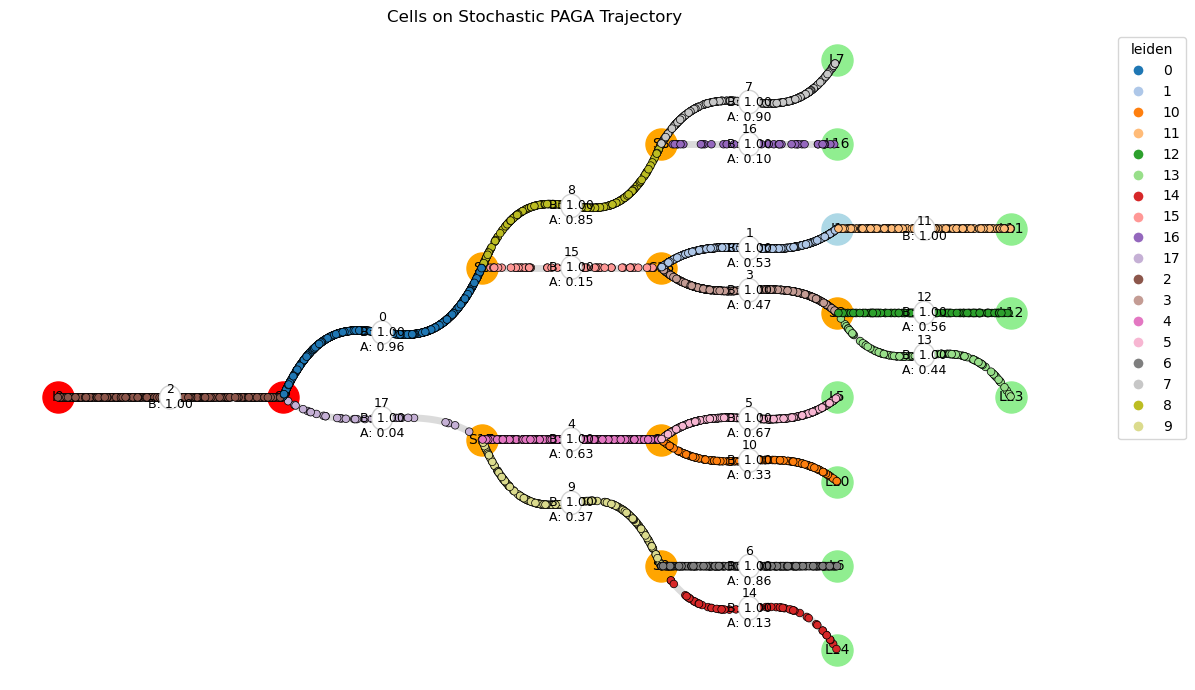

In [4]:
# Visualize trajectory graph with cells assigned
traj_graph.plot_cells_on_trajectory(
    cell_assignment=cell_assignment,
    color_key='leiden',
    curve_amount=0.8,
    node_size=500,
    cell_size=30,
    horizontal_thresh=0.01,
    edge_width=5,
    edge_color='lightgrey',
    title="Cells on Stochastic PAGA Trajectory",
    plot_transitions=True
)


In [28]:
cell_assignment

,edge,latent_time
TAAGCGTAGGCCCGTT,"(split_7, leaf_4)",0.773956
GACCAATAGTCGTCGT,"(split_3, split_8)",0.438878
CGAGAAGCATGCTAGT,"(split_7, leaf_4)",0.858598
ACGATGTAGGATTCCC,"(split_7, leaf_4)",0.697368
GCAGTTAAGGTCATCT,"(split_7, leaf_4)",0.094177
...,...,...
GGAGCAAGTCTAGTGT,"(int_11, leaf_13)",0.445600
TTTACTGTCAGTTCGG,"(split_8, leaf_12)",0.005850
GAAATGAGTCGGCACT,"(split_8, leaf_12)",0.574462
CGATGGCAGTGTCTCG,"(split_8, leaf_12)",0.747506


In [5]:
import time
import numpy as np
import pandas as pd
import torch
from scipy.optimize import minimize_scalar
import scipy.sparse as sp

from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict
from joblib import Parallel, delayed
import tempfile

import os

class EMTrainer:
    """
    EMTrainer performs iterative Expectation-Maximization over a trajectory graph with cells assigned
    to continuous positions along edges. It alternates between:
        - (E-step) Cell reassignment via Brent optimization
        - (M-step) Emission parameter updates (g, r²) and K optimization (PyTorch)
        - Optional: structure pruning for underpopulated edges
    Supports multithreading, GPU acceleration, and rich debugging/logging.
    """

    def __init__(self, traj_graph, cell_assignment, *, verbose=True, debug=False, timer=True):
        self.traj_graph = traj_graph
        self.cell_assignment = cell_assignment
        self.verbose = verbose
        self.debug = debug
        self.timer = timer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def _initialize_K_from_expression(self):
        for edge_idx, (u_idx, v_idx) in enumerate(self.traj_graph.edge_list):
            g_a = self.traj_graph.node_emission[u_idx]
            g_b = self.traj_graph.node_emission[v_idx]
            delta = g_a - g_b
            with np.errstate(divide='ignore', invalid='ignore'):
                inferred_K = -np.log(np.clip(delta / g_a, 1e-3, 1.0))
                inferred_K = np.nan_to_num(inferred_K, nan=1.0, posinf=10.0, neginf=0.1)
                inferred_K = np.clip(inferred_K, 1e-2, 10.0)
            self.traj_graph.emission_params[edge_idx]['K'] = inferred_K


    def _log(self, msg):
        if self.verbose:
            print(msg)

    def _time(self, label, func, *args, **kwargs):
        if self.timer:
            start = time.time()
            result = func(*args, **kwargs)
            end = time.time()
            print(f"⏱️ {label} took {end - start:.2f} seconds")
            return result
        return func(*args, **kwargs)

    def remap_edges_to_indices(self):
        node_to_index = self.traj_graph.node_to_index
        def convert(e):
            return (
                node_to_index[e[0]] if isinstance(e[0], str) else e[0],
                node_to_index[e[1]] if isinstance(e[1], str) else e[1]
            )
        self.cell_assignment['edge'] = self.cell_assignment['edge'].apply(convert)


    def remap_edges_to_names(self):
        index_to_name = self.traj_graph.index_to_node
        def convert(e):
            return (
                index_to_name[e[0]] if isinstance(e[0], int) else e[0],
                index_to_name[e[1]] if isinstance(e[1], int) else e[1]
            )
        self.cell_assignment['edge'] = self.cell_assignment['edge'].apply(convert)


    def _optimize_K_parameters(self, lr=0.1, max_epochs=100, tol=1e-5, verbose=True, debug=False):
        X = torch.tensor(self.traj_graph.adata.X, dtype=torch.float32, device=self.device)
        cell_to_index = {cell: idx for idx, cell in enumerate(self.traj_graph.adata.obs_names)}
    
        for edge, edge_idx in self.traj_graph.edge_tuple_to_index.items():
            df = self.cell_assignment[self.cell_assignment['edge'] == edge]
            if df.empty:
                continue
    
            u_idx, v_idx = edge
            g_a = torch.tensor(self.traj_graph.node_emission[u_idx], dtype=torch.float32, device=self.device)
            g_b = torch.tensor(self.traj_graph.node_emission[v_idx], dtype=torch.float32, device=self.device)
            params = self.traj_graph.emission_params[edge_idx]
    
            K = torch.tensor(params['K'], dtype=torch.float32, requires_grad=True, device=self.device)
            r2 = torch.tensor(np.clip(params['r2'], 1e-4, np.inf), dtype=torch.float32, device=self.device)
    
            t_values = torch.tensor(df['latent_time'].values, dtype=torch.float32, device=self.device)
            expr_matrix = torch.stack([X[cell_to_index[cell]] for cell in df.index])  # shape: (n_cells, n_genes)
    
            if debug:
                print(f"\n🧠 Edge {edge} - Initial mean K: {K.mean().item():.4f} | n_cells={len(t_values)}")
    
            for epoch in range(max_epochs):
                exp_term = torch.exp(-K[None, :] * t_values[:, None])
                preds = g_b + (g_a - g_b) * exp_term
                residuals = expr_matrix - preds
    
                # Negative log likelihood per cell
                nll = (residuals ** 2) / (2 * r2) + 0.5 * torch.log(2 * torch.pi * r2)
                loss = torch.mean(torch.sum(nll, dim=1))  # mean over cells
    
                loss.backward()
    
                with torch.no_grad():
                    grad_norm = K.grad.norm().item()
                    delta = (lr * K.grad).norm().item()
                    K -= lr * K.grad
                    K.clamp_(1e-3, 10.0)
                    K.grad.zero_()
    
                if debug and (epoch % 10 == 0 or epoch == max_epochs - 1):
                    print(f"  Epoch {epoch+1:03d} | NLL: {loss.item():.6f} | ΔK: {delta:.4e} | Grad ∥: {grad_norm:.4e}")
    
                if delta < tol:
                    if debug:
                        print(f"  ✅ Converged at epoch {epoch+1} with ΔK = {delta:.4e}")
                    break
    
            self.traj_graph.emission_params[edge_idx]['K'] = K.detach().cpu().numpy()
    
            if verbose:
                print(f"✅ Edge {edge} | Final K mean: {K.mean().item():.4f} | Last NLL: {loss.item():.6f}")

    def _optimize_emission_parameters_l1(self, lamb=1.0, var_thresh=0.001, delta_thresh=0.01, n_jobs=8):
        import cvxpy as cp
    
        X = np.asarray(self.traj_graph.adata.X)
        cell_to_index = {cell: idx for idx, cell in enumerate(self.traj_graph.adata.obs_names)}
        edge_list = self.traj_graph.edge_list
        node_to_index = self.traj_graph.node_to_index
        n_nodes = len(node_to_index)
        n_genes = X.shape[1]
    
        # --- Precompute A2 (edge regularization matrix) ---
        row_indices, col_indices, data = [], [], []
        for i, (u_idx, v_idx) in enumerate(edge_list):
            row_indices.extend([i, i])
            col_indices.extend([u_idx, v_idx])
            data.extend([lamb, -lamb])
        A2 = sp.csr_matrix((data, (row_indices, col_indices)), shape=(len(edge_list), n_nodes))
    
        # --- Identify informative genes ---
        var_mask = np.var(X, axis=0) >= var_thresh
        delta_mask = np.zeros(n_genes, dtype=bool)
        for (u_idx, v_idx) in edge_list:
            g_a = self.traj_graph.node_emission[u_idx]
            g_b = self.traj_graph.node_emission[v_idx]
            delta = np.abs(g_a - g_b)
            delta_mask |= delta >= delta_thresh
    
        informative_genes = np.where(var_mask & delta_mask)[0]
    
        if self.verbose:
            print(f"🧬 Retaining {len(informative_genes)}/{n_genes} informative genes for optimization.")
    
        # --- Per-gene optimizer ---
        def fit_gene(j):
            Xj = []
            row_idx, col_idx, data = [], [], []
            for i, (cell, row) in enumerate(self.cell_assignment.iterrows()):
                u_name, v_name = row['edge']
                u = node_to_index[u_name]
                v = node_to_index[v_name]
                t = row['latent_time']
                edge_idx = self.traj_graph.edge_tuple_to_index[(u, v)]
                K = self.traj_graph.emission_params[edge_idx]['K'][j]
    
                w_u = np.exp(-K * t)
                w_v = 1 - w_u
    
                row_idx.extend([i, i])
                col_idx.extend([u, v])
                data.extend([w_u, w_v])
                Xj.append(X[cell_to_index[cell], j])
    
            if not Xj:
                return j, np.zeros(n_nodes)
    
            A1 = sp.csr_matrix((data, (row_idx, col_idx)), shape=(len(Xj), n_nodes))
            Xj = np.array(Xj)
    
            g_j = cp.Variable(n_nodes)
            objective = cp.Minimize(cp.sum_squares(A1 @ g_j - Xj) + cp.norm1(A2 @ g_j))
            prob = cp.Problem(objective)
    
            try:
                prob.solve(solver=cp.SCS, verbose=False, eps=1e-4, max_iters=1000)
            except cp.SolverError:
                prob.solve(solver=cp.ECOS, verbose=False)
    
            if g_j.value is None:
                return j, np.zeros(n_nodes)
            return j, g_j.value
    
        # --- Run in parallel ---
        G = np.zeros((n_nodes, n_genes))
        results = Parallel(n_jobs=n_jobs)(
            delayed(fit_gene)(j) for j in informative_genes
        )
        for j, g_j in results:
            G[:, j] = g_j
    
        # --- Fallback: simple means for unoptimized genes ---
        missing_genes = set(range(n_genes)) - set(j for j, _ in results)
        if self.verbose:
            print(f"🛟 Falling back to mean-based emission updates for {len(missing_genes)} genes.")
    
        for j in missing_genes:
            node_expr = defaultdict(list)
            for cell, row in self.cell_assignment.iterrows():
                u_name, v_name = row['edge']
                u_idx = node_to_index[u_name]
                v_idx = node_to_index[v_name]
                x_j = X[cell_to_index[cell], j]
                node_expr[u_idx].append(x_j)
                node_expr[v_idx].append(x_j)
            for i in range(n_nodes):
                G[i, j] = np.mean(node_expr[i]) if node_expr[i] else 0.0
    
        # --- Assign to node_emission ---
        self.traj_graph.node_emission = {
            node: G[i] for i, node in enumerate(node_to_index.values())
        }


    def _best_edge_for_cell(self, cell_idx, x_i):
        best_score = np.inf
        best_edge = None
        best_t = None

        for edge_idx, (u_idx, v_idx) in enumerate(self.traj_graph.edge_list):
            g_a = self.traj_graph.node_emission[u_idx]
            g_b = self.traj_graph.node_emission[v_idx]
            params = self.traj_graph.emission_params[edge_idx]
            K = params['K']
            r2 = np.clip(params['r2'], 1e-4, np.inf)

            def neg_log_likelihood(t):
                exp_term = np.exp(-K * t)
                f_t = g_b + (g_a - g_b) * exp_term
                return np.sum((x_i - f_t) ** 2 / (2 * r2))  # no constant

            result = minimize_scalar(neg_log_likelihood, bounds=(0, 1), method='bounded')
            if result.fun < best_score:
                best_score = result.fun
                best_edge = (u_idx, v_idx)
                best_t = result.x

        return (cell_idx, best_edge, best_t)
    
    def _reassign_cells(self, max_workers=None):
        if max_workers is None:
            max_workers = max(os.cpu_count() - 1, 1)
        # Step 1: Memory-map X
        X = np.asarray(self.traj_graph.adata.X)
        temp_dir = tempfile.gettempdir()
        mmap_path = os.path.join(temp_dir, f'X_memmap_{id(self)}.npy')
        np.save(mmap_path, X)  # always save fresh version
        X_shared = np.load(mmap_path, mmap_mode='r')
    
        # Step 2: Build kinetic model
        kinetic_model = {}
        for (u_idx, v_idx), edge_idx in self.traj_graph.edge_tuple_to_index.items():
            g_a = self.traj_graph.node_emission[u_idx]
            g_b = self.traj_graph.node_emission[v_idx]
            params = self.traj_graph.emission_params[edge_idx]
            kinetic_model[(u_idx, v_idx)] = {
                "g_a": g_a,
                "g_b": g_b,
                "K": params["K"],
                "r2": np.clip(params["r2"], 1e-4, np.inf)
            }
    
        # Step 3: Define external worker function
        def assign_cell_to_best_edge(cell_idx, x_i, model, index_to_name):
            best_score = np.inf
            best_edge = None
            best_t = None
            for (u, v), params in model.items():
                K = params["K"]
                r2 = params["r2"]
                g_a = params["g_a"]
                g_b = params["g_b"]
    
                def neg_log_likelihood(t):
                    f_t = g_b + (g_a - g_b) * np.exp(-K * t)
                    return np.sum((x_i - f_t) ** 2 / (2 * r2))
    
                result = minimize_scalar(neg_log_likelihood, bounds=(0, 1), method='bounded')
                if result.fun < best_score:
                    best_score = result.fun
                    best_edge = (u, v)
                    best_t = result.x
    
            return (cell_idx, (index_to_name[best_edge[0]], index_to_name[best_edge[1]]), best_t)
    
        # Step 4: Launch in parallel
        C = X_shared.shape[0]
        index_to_name = self.traj_graph.index_to_node
        results = Parallel(n_jobs=max_workers)(
            delayed(assign_cell_to_best_edge)(i, X_shared[i], kinetic_model, index_to_name)
            for i in range(C)
        )
        results.sort()  # sort by cell_idx
        # Step 5: Build DataFrame
        cell_names = self.traj_graph.adata.obs_names
        reassigned = pd.DataFrame(index=cell_names)
        reassigned['edge'] = [edge for _, edge, _ in results]
        reassigned['latent_time'] = [t for _, _, t in results]
    
        return reassigned

    def _optimize_structure_and_reassign(self, min_cells=3):
        G = self.traj_graph.G_traj.copy()
        node_to_index = self.traj_graph.node_to_index
        index_to_node = self.traj_graph.index_to_node
    
        # Group cells by edge
        edge_to_cells = defaultdict(list)
        for cell, row in self.cell_assignment.iterrows():
            edge = row['edge']
            edge_to_cells[edge].append(cell)
    
        # Identify underpopulated edges
        removed_edges = [edge for edge, cells in edge_to_cells.items() if len(cells) < min_cells]
    
        if self.verbose:
            print(f"🧹 Removing {len(removed_edges)} edges with < {min_cells} cells.")
        if len(removed_edges) == 0:
            return self.traj_graph, self.cell_assignment
    
        # Convert to sets for fast batch operations
        removed_edges_set = set(removed_edges)
        removed_edges_int = set(
            (node_to_index[u], node_to_index[v]) for (u, v) in removed_edges if u in node_to_index and v in node_to_index
        )
    
        # Batch remove edges from G
        G.remove_edges_from(removed_edges)
    
        # Batch update edge_list, emission dicts, and tuple index
        self.traj_graph.edge_list = [e for e in self.traj_graph.edge_list if e not in removed_edges_int]
        for edge in removed_edges_int:
            self.traj_graph.edge_tuple_to_index.pop(edge, None)
        all_dropped_idxs = {idx for idx, edge in self.traj_graph.edge_tuple_to_index.items() if edge in removed_edges_int}
        for idx in all_dropped_idxs:
            self.traj_graph.emission_params.pop(idx, None)
    
        # Determine orphans and pruned parents
        in_deg = dict(G.in_degree())
        out_deg = dict(G.out_degree())
        parents = {u for u, _ in G.edges()}
        children = {v for _, v in G.edges()}
        all_nodes = set(G.nodes())
    
        orphans = [n for n in all_nodes if n not in parents and in_deg.get(n, 0) > 0]
        pruned = [n for n in all_nodes if n not in children and out_deg.get(n, 0) > 0]
    
        if self.verbose:
            print(f"🌿 {len(orphans)} orphan nodes and {len(pruned)} pruned parent nodes")
    
        if not orphans or not pruned:
            self.traj_graph.G_traj = G
            return self.traj_graph, self.cell_assignment
    
        # Cache emissions for all orphans and pruned nodes
        orphan_vecs = {
            o: self.traj_graph.node_emission[node_to_index[o]]
            for o in orphans
        }
        pruned_vecs = {
            p: self.traj_graph.node_emission[node_to_index[p]]
            for p in pruned
        }
    
        # Attempt reconnection
        new_edges = []
        added_emission_params = {}
        max_edge_idx = max(self.traj_graph.edge_tuple_to_index.values(), default=-1) + 1
    
        for orphan in orphans:
            # Filter valid parent candidates
            orphan_lvl = self.traj_graph.levels.get(orphan.split('_')[-1], 999)
            candidates = [
                p for p in pruned
                if out_deg.get(p, 0) < 2
                and not p.startswith("RootNode")
                and self.traj_graph.levels.get(p.split('_')[-1], 0) < orphan_lvl
            ]
            if not candidates:
                continue
    
            best_parent = min(
                candidates,
                key=lambda p: np.linalg.norm(pruned_vecs[p] - orphan_vecs[orphan])
            )
    
            G.add_edge(best_parent, orphan)
            if self.verbose:
                print(f"🔁 Reconnected {orphan} to {best_parent}")
    
            u = node_to_index[best_parent]
            v = node_to_index[orphan]
            new_edges.append((u, v))
            self.traj_graph.edge_tuple_to_index[(u, v)] = max_edge_idx
            added_emission_params[max_edge_idx] = {
                'K': np.ones(self.traj_graph.adata.X.shape[1]),
                'r2': np.ones(self.traj_graph.adata.X.shape[1]),
                'pi': np.zeros(self.traj_graph.adata.X.shape[1])
            }
            max_edge_idx += 1
    
        # Commit batched updates
        self.traj_graph.G_traj = G
        self.traj_graph.edge_list.extend(new_edges)
        self.traj_graph.emission_params.update(added_emission_params)
    
        # Reassign only cells affected by removed edges
        cells_to_reassign = [cell for edge in removed_edges for cell in edge_to_cells[edge]]
        reassignment_df = self._reassign_cells()
        reassignment_df = reassignment_df.loc[cells_to_reassign]
        self.cell_assignment.update(reassignment_df)
    
        if self.verbose:
            print(f"✅ Reassigned {len(cells_to_reassign)} cells after pruning")
    
        return self.traj_graph, self.cell_assignment

    def run_em(self, n_iterations=5, **kwargs):
        self._log("\n📈 Initializing K from g_a, g_b deltas...")
        self._initialize_K_from_expression()

        for i in range(n_iterations):
            print(f"\n🌀 EM ITERATION {i+1}/{n_iterations}")
            
            self._log("\n🧠 Optimizing K parameters (PyTorch)...")
            self.remap_edges_to_indices()
            self._time("K optimization", self._optimize_K_parameters,
                       lr=kwargs.get("optimize_K_lr", 0.05),
                       max_epochs=kwargs.get("optimize_K_epochs", 100),
                       tol=kwargs.get("optimize_K_tol", 1e-5),
                       verbose=self.verbose,
                       debug=self.debug)

            self._log("\n📊 Recalculating emission parameters (g, r²)...")
            self.remap_edges_to_names()
            self._time("Emission parameter update", self._optimize_emission_parameters_l1)



            self._log("\n🔁 Reassigning cells (E-step)...")
            self.cell_assignment = self._time("Cell reassignment", self._reassign_cells,
                                              max_workers=kwargs.get("reassign_workers", 8))

            self.remap_edges_to_names()

            if kwargs.get("prune_structure", True):
                self._log("\n🌿 Pruning and reattaching edges...")
                self.traj_graph, self.cell_assignment = self._time("Structure step",
                                                                   self._optimize_structure_and_reassign,
                                                                   min_cells=kwargs.get("min_cells", 3))
            self._log("\n📊 Recalculating emission parameters (g, r²)...")
            self.remap_edges_to_names()
            self._time("Emission parameter update", self._optimize_emission_parameters_l1)


            if kwargs.get("plot", True):
                self._log("\n🎨 Plotting updated trajectory...")
                self.traj_graph.plot_cells_on_trajectory(
                    cell_assignment=self.cell_assignment,
                    color_key='leiden',
                    curve_amount=0.8,
                    node_size=500,
                    cell_size=30,
                    horizontal_thresh=0.01,
                    edge_width=5,
                    edge_color='lightgrey',
                    title=f"EM Iteration {i+1}",
                    plot_transitions=True
                )

            self.remap_edges_to_indices()

        return self.traj_graph, self.cell_assignment


In [6]:
trainer = EMTrainer(traj_graph, cell_assignment, verbose=True, debug=False, timer=True)
traj_graph, new_cell_assignment = trainer.run_em(
    n_iterations=5,
    min_cells=3,
    reassign_workers=12,
    optimize_K_lr=0.05,
    optimize_K_epochs=500,
    optimize_K_tol=1e-5,
    plot=True
)



📈 Initializing K from g_a, g_b deltas...


KeyError: 0

In [ ]:
    def _reassign_cells_legacy(self, cell_subset=None, max_workers=None, n_neighbors=None, mask_edges=None, branch_weight=1.0):
        # --- Setup (mostly unchanged) ---
        e_step_start_time = time.time()
        if max_workers is None:
            max_workers = max(os.cpu_count() - 1, 1)
        if self.verbose:
            print(f"[E-STEP Setup] Using max_workers = {max_workers}")
            print(f"[E-STEP Setup] n_neighbors = {n_neighbors}, branch_weight = {branch_weight}")

        _ = self.cell_to_index
        if self.verbose: print("[E-STEP Setup] Loading shared expression matrix X...")
        load_X_start = time.time()
        X_shared = self._load_shared_X()
        if self.verbose: print(f"[E-STEP Setup] Loaded X_shared in {time.time() - load_X_start:.4f}s")
        try:
            X_access = np.array(X_shared, dtype=np.float32)
            if self.verbose: print("[E-STEP Setup] Using X loaded into RAM.")
        except MemoryError:
            if self.verbose: print("[WARN] Not enough RAM to load X fully, using memory map.")
            X_access = X_shared

        # --- Determine Globally Valid Edges & Apply Masking ---
        valid_edges_setup_start = time.time()
        mask_edges_set = set(mask_edges or [])
        all_current_graph_edges_set = set(self.traj_graph.edge_list) # Use set for efficient lookup

        # Globally valid edges are those in the graph *not* explicitly masked
        globally_valid_edges_set = all_current_graph_edges_set - mask_edges_set

        if not globally_valid_edges_set:
             raise RuntimeError("No valid (unmasked) edges available for cell reassignment.")
        if self.verbose:
            print(f"[E-STEP Setup] Total graph edges: {len(all_current_graph_edges_set)}")
            print(f"[E-STEP Setup] Masked edges: {len(mask_edges_set)}")
            print(f"[E-STEP Setup] Globally valid edges for potential assignment: {len(globally_valid_edges_set)}")
            print(f"[E-STEP Setup] Valid edge setup took {time.time() - valid_edges_setup_start:.4f}s")

        # --- Calculate log branch penalties (for globally valid edges) ---
        # Compute only once for all edges that *might* be considered
        branch_calc_start = time.time()
        log_branch_penalty_dict = {}
        if branch_weight > 0:
            try:
                 if self.verbose: print("[E-STEP Branch Prior] Calculating branch priors for globally valid edges...")
                 # Pass the set converted to list
                 _, edge_log_priors = self.traj_graph.get_branch_paths_for_edges(edges=list(globally_valid_edges_set))
                 log_branch_penalty_dict = {
                     e: -branch_weight * edge_log_priors.get(e, np.log(1e-9))
                     for e in globally_valid_edges_set # Only store penalties for valid edges
                 }
                 if self.verbose: print(f"[E-STEP Branch Prior] Calculated {len(log_branch_penalty_dict)} branch penalties.")
            except Exception as e:
                 print(f"[ERROR] Failed to calculate branch priors: {e}. Proceeding without branch penalty.")
                 log_branch_penalty_dict = {e: 0.0 for e in globally_valid_edges_set}
        else:
            if self.verbose: print("[E-STEP Branch Prior] branch_weight is 0, skipping prior calculation.")
            log_branch_penalty_dict = {e: 0.0 for e in globally_valid_edges_set}
        if self.verbose: print(f"[E-STEP Branch Prior] Branch penalty calculation took {time.time() - branch_calc_start:.4f}s")

        # --- PRE-COMPUTE Edge-to-Candidate Mapping ---
        precompute_start = time.time()
        edge_to_candidate_list_map = {}
        
        if n_neighbors is None:
            fallback_candidate_list = list(globally_valid_edges_set)
            if self.verbose:
                print(f"[E-STEP Precompute] n_neighbors is None. All cells will check {len(fallback_candidate_list)} valid edges.")
        else:
            if self.verbose:
                print(f"[E-STEP Precompute] Pre-calculating candidate edges for n_neighbors={n_neighbors}...")
            edges_to_compute_for = all_current_graph_edges_set
        
            for edge in edges_to_compute_for:
                if edge not in self.traj_graph.G_traj.edges:
                    continue
        
                if n_neighbors == 0:
                    candidate_list = [edge]
                else:
                    candidate_list = self._get_neighboring_edges_for_edge(edge, n_neighbors, all_current_graph_edges_set)
        
                edge_to_candidate_list_map[edge] = candidate_list
        
            fallback_candidate_list = list(globally_valid_edges_set)
            if self.verbose:
                print(f"[E-STEP Precompute] Pre-computation finished in {time.time() - precompute_start:.4f}s.")

        if self.verbose: print("[E-STEP Setup] Building integer-indexed data arrays...")
        array_build_start = time.time()
    
        # --- Get current mappings ---
        mappings = self._build_index_mappings()
        node_name_to_int = mappings["node_name_to_int"]
        int_to_node_name = mappings["int_to_node_name"] # Needed for result mapping back
        edge_name_to_int = mappings["edge_to_int"]
        int_to_edge_name = mappings["int_to_edge"] # Needed for result mapping back
    
        n_nodes = len(node_name_to_int)
        n_edges = len(edge_name_to_int)
        n_genes = self.traj_graph.adata.shape[1]
    
        # --- Create integer-indexed arrays ---
        g_array = np.zeros((n_nodes, n_genes), dtype=np.float32)
        K_array = np.ones((n_edges, n_genes), dtype=np.float32) # Default K=1
        # Store the raw negative log prior; weight applied later
        final_penalty_array = np.zeros(n_edges, dtype=np.float32)
    
        # --- Populate g_array ---
        for node_name, node_idx in node_name_to_int.items():
            if node_name in self.traj_graph.node_emission:
                g_array[node_idx] = self.traj_graph.node_emission[node_name]
    
        # --- Populate K_array and final_penalty_array ---
        # log_branch_penalty_dict was computed earlier
        for edge_tuple, edge_idx in edge_name_to_int.items():
            if edge_tuple in self.traj_graph.emission_params:
                params = self.traj_graph.emission_params[edge_tuple]
                if 'K' in params:
                    K_array[edge_idx] = params['K']
            # Store penalty = -log(Prior). Weight applied later.
            final_penalty_array[edge_idx] = log_branch_penalty_dict.get(edge_tuple, 0.0) # Use large positive penalty if missing
    
        # --- Prepare r2 array ---
        if self.traj_graph.global_r2 is None: raise RuntimeError("Global r² is not initialized.")
        safe_global_r2 = np.clip(self.traj_graph.global_r2, 1e-9, np.inf)
        inv_2r2_global_array = (1.0 / (2.0 * safe_global_r2)).astype(np.float32)
    
        # --- Precompute edge_int -> (u_int, v_int) mapping ---
        edge_int_to_node_int_pairs = {}
        for edge_idx, edge_name in int_to_edge_name.items():
             u_name, v_name = edge_name
             if u_name in node_name_to_int and v_name in node_name_to_int:
                 edge_int_to_node_int_pairs[edge_idx] = (node_name_to_int[u_name], node_name_to_int[v_name])
    
        if self.verbose: print(f"[E-STEP Setup] Built arrays in {time.time() - array_build_start:.4f}s")

        # --- Determine target cells (unchanged) ---
        if cell_subset is None:
            selected_cells = self.traj_graph.adata.obs_names
        else:
            selected_cells = pd.Index([c for c in cell_subset if c in self.cell_to_index])
        cell_indices_map = {self.cell_to_index[c]: c for c in selected_cells} # Map idx -> name
        cell_original_indices = list(cell_indices_map.keys())
        if self.verbose: print(f"[E-STEP Setup] Reassigning {len(cell_original_indices)} cells.")

        # --- Get global r2 (unchanged) ---
        r2_global = self.traj_graph.global_r2
        if r2_global is None: raise RuntimeError("Global r² is not initialized.")
        if np.any(r2_global <= 0):
             if self.verbose: print("[WARN] Global r² clipped to 1e-9.")
             r2_global = np.clip(r2_global, 1e-9, np.inf)
        if self.verbose: print(f"[E-STEP Setup] Using global_r2 (shape: {r2_global.shape})")

        # --- Prepare Per-Cell Tasks for Parallel Execution ---
        prep_tasks_start = time.time()
        tasks_to_submit = []
        # Cache neighborhoods if n_neighbors is used
        edge_neighborhood_cache = {}

        for cell_batch_idx, cell_original_idx in enumerate(cell_original_indices):
            cell_name = cell_indices_map[cell_original_idx]
            # Get current edge (handle possibility cell not currently assigned, e.g., after pruning)
            current_edge = self.cell_assignment.get('edge', {}).get(cell_name, None)

            # --- Determine Candidate Edges Using Precomputed Map ---
            if n_neighbors is None:
                cell_candidate_list_unmasked = fallback_candidate_list
            elif current_edge in edge_to_candidate_list_map:
                cell_candidate_list_unmasked = edge_to_candidate_list_map[current_edge]
            else:
                if self.verbose and cell_batch_idx < 10:
                    print(f"[E-STEP Task Prep] Cell {cell_name} (idx {cell_original_idx}) has invalid/unmapped current edge '{current_edge}'. Using fallback.")
                cell_candidate_list_unmasked = fallback_candidate_list
            
            # --- Apply Masking ---
            cell_candidate_list = [e for e in cell_candidate_list_unmasked if e not in mask_edges_set]
            
            # --- Handle Edge Masking when n_neighbors == 0 ---
            if n_neighbors == 0 and current_edge in mask_edges_set:
                if self.verbose and cell_batch_idx < 10:
                    print(f"[E-STEP Task Prep] Cell {cell_name} on masked edge {current_edge} with n_neighbors=0. Expanding to n=1 neighbors.")
                neighbors_n1 = self._get_neighboring_edges_for_edge(current_edge, 1, all_current_graph_edges_set)
                cell_candidate_list = [e for e in neighbors_n1 if e not in mask_edges_set]
            
                if not cell_candidate_list:
                    if self.verbose:
                        print(f"[WARN] Cell {cell_name} has no viable neighbors after mask. Using full fallback.")
                    cell_candidate_list = fallback_candidate_list


                # --- Convert allowed edge tuples to integer indices ---
            cell_allowed_edge_indices = []
            for edge_tuple in cell_candidate_list:
                edge_idx = edge_name_to_int.get(edge_tuple, -1) # Use .get for safety
                if edge_idx != -1:
                    cell_allowed_edge_indices.append(edge_idx)
            
            # --- Final Check and Task Creation ---
            if not cell_candidate_list:
                if self.verbose:
                    print(f"[WARN] Cell {cell_name} (idx {cell_original_idx}) ended up with zero candidate edges after masking. Skipping assignment.")
                continue


            # Add task details to the list
            task_args = {
                'cell_original_idx': cell_original_idx,
                'x_i': X_access[cell_original_idx], # Pass array slice
                'allowed_edge_indices': cell_allowed_edge_indices, # Pass INT indices
                'g_array': g_array, # Pass arrays (read-only)
                'K_array': K_array,
                'inv_2r2_global_array': inv_2r2_global_array,
                'final_penalty_array': final_penalty_array, # Pass array of pre-calculated -log(priors)
                'edge_int_to_node_int_pairs': edge_int_to_node_int_pairs, # Pass map
                'verbose': self.verbose and (cell_batch_idx < 5),
                'cell_batch_idx': cell_batch_idx
            }
            tasks_to_submit.append(task_args)

        if self.verbose: print(f"[E-STEP Task Prep] Prepared {len(tasks_to_submit)} tasks in {time.time() - prep_tasks_start:.4f}s.")


        # --- Execute in Parallel ---
        if not tasks_to_submit:
             print("[WARN] No tasks to submit for parallel execution.")
             return pd.DataFrame(columns=['edge', 'latent_time']), 0.0

        if self.verbose: print(f"[E-STEP Parallel] Submitting {len(tasks_to_submit)} tasks to ThreadPoolExecutor...")
        parallel_start_time = time.time()
        futures = []
        results_list = []
        processed_count = 0

        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            for task_args in tasks_to_submit:
                # Submit using the dictionary arguments
                future = executor.submit(self._static_worker_assign_cell, **task_args) # NEW - Points to static function
                futures.append(future)

            # Collect results (unchanged)
            for future in as_completed(futures):
                try:
                    result = future.result()
                    results_list.append(result)
                    processed_count += 1
                    if self.verbose and (processed_count % 1000 == 0 or processed_count == len(tasks_to_submit)):
                         current_time = time.time()
                         print(f"[E-STEP Parallel] Processed {processed_count}/{len(tasks_to_submit)} cells... (elapsed: {current_time - parallel_start_time:.2f}s)")
                except Exception as e:
                    print(f"[ERROR] Worker thread failed: {e}")

        if self.verbose: print(f"[E-STEP Parallel] Parallel execution finished in {time.time() - parallel_start_time:.2f}s. Collected {len(results_list)} results.")

        # --- Process Results (largely unchanged, ensure indices match) ---
        process_results_start = time.time()
        results = results_list

        valid_results = [r for r in results if r is not None and r[1] is not None]
        if self.verbose: print(f"[E-STEP Results] Filtered {len(valid_results)} valid results from {len(results)} raw results.")

        # Check which *original target* cells got a valid assignment back
        assigned_original_indices = {r[0] for r in valid_results}
        original_indices_set = set(cell_original_indices) # Use the list of indices we intended to process
        missing_indices = original_indices_set - assigned_original_indices
        if missing_indices:
            missing_cell_names = [self.traj_graph.adata.obs_names[idx] for idx in missing_indices]
            print(f"[WARN] {len(missing_indices)} intended cells were not assigned: {missing_cell_names[:10]}...")

        if not valid_results:
             print("[WARN] No cells were successfully reassigned. Returning empty DataFrame.")
             return pd.DataFrame(columns=['edge', 'latent_time']), 0.0

        valid_results.sort(key=lambda x: x[0])
        result_cell_names = [self.traj_graph.adata.obs_names[i] for i, *_ in valid_results]
        reassigned = pd.DataFrame(index=result_cell_names)
    
        # Map edge index back to tuple using int_to_edge_name map
        reassigned['edge'] = [int_to_edge_name[edge_idx] for _, edge_idx, _, _ in valid_results] # MODIFIED
        reassigned['latent_time'] = [t for _, _, t, _ in valid_results]
        total_loss = sum(score for *_, score in valid_results if np.isfinite(score))

        if self.verbose:
            print(f"[E-STEP Results] Result processing took {time.time() - process_results_start:.4f}s")
            print(f"[E-STEP Summary] Total E-step took {time.time() - e_step_start_time:.2f}s")
            print(f"[E-STEP Summary] Calculated total_loss = {total_loss:.4f}")

        return reassigned, total_loss

In [ ]:
import time
import numpy as np
import pandas as pd
import torch
from scipy.optimize import minimize_scalar
from scipy.sparse.linalg import spsolve
from sksparse.cholmod import cholesky
from scipy.sparse.linalg import splu
import scipy.sparse as sp
import networkx as nx
from collections import defaultdict
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed
import tempfile

import os

class EMTrainer:
    """
    EMTrainer performs iterative Expectation-Maximization over a trajectory graph with cells assigned
    to continuous positions along edges. It alternates between:
        - (E-step) Cell reassignment via Brent optimization
        - (M-step) Emission parameter updates (g, r²) and K optimization (PyTorch)
        - Optional: structure pruning for underpopulated edges
    Supports multithreading, GPU acceleration, and rich debugging/logging.
    """

    # _________ Utilities _____________
    def __init__(self, traj_graph, cell_assignment, *, verbose=True, debug=False, timer=True):
        self.traj_graph = traj_graph
        self.cell_assignment = cell_assignment
        self.verbose = verbose
        self.debug = debug
        self.timer = timer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    def _log(self, msg):
        if self.verbose:
            print(msg)

    def _time(self, label, func, *args, **kwargs):
        if self.timer:
            start = time.time()
            result = func(*args, **kwargs)
            end = time.time()
            print(f"⏱️ {label} took {end - start:.2f} seconds")
            return result
        return func(*args, **kwargs)

    def _cleanup_shared_resources(self):
        """Safely remove any shared memory files or temp artifacts."""
        if hasattr(self, '_mmap_path') and os.path.exists(self._mmap_path):
            try:
                os.remove(self._mmap_path)
            except Exception as e:
                if self.verbose:
                    print(f"[WARN] Failed to delete shared memory file: {e}")
            finally:
                del self._mmap_path

    def _build_index_mappings(self):
        """
        Build consistent integer mappings for nodes and edges.
        These are ephemeral and should be rebuilt any time the graph is mutated.
        """
        node_names = list(self.traj_graph.node_emission.keys())
        edge_list = self.traj_graph.edge_list
    
        node_name_to_int = {name: i for i, name in enumerate(node_names)}
        int_to_node_name = {i: name for name, i in node_name_to_int.items()}
        edge_to_int = {edge: i for i, edge in enumerate(edge_list)}
        int_to_edge = {i: edge for edge, i in edge_to_int.items()}
    
        return {
            "node_name_to_int": node_name_to_int,
            "int_to_node_name": int_to_node_name,
            "edge_to_int": edge_to_int,
            "int_to_edge": int_to_edge,
        }
        
    @property
    def cell_to_index(self):
        """Lazily construct a cell name → row index mapping for adata.X"""
        if not hasattr(self, '_cell_to_index'):
            self._cell_to_index = {
                cell: idx for idx, cell in enumerate(self.traj_graph.adata.obs_names)
            }
        return self._cell_to_index
        
    @staticmethod
    def compute_soft_assignment(K, t):
        """Compute soft weights (w_u, w_v) given decay K and latent time t"""
        w_u = np.exp(-K * t)
        w_v = 1.0 - w_u
        return w_u, w_v
        
    def _assert_all_cells_assigned(self):
        """Raise if any cell from the original adata is not assigned to a valid edge."""
        expected_cells = set(self.traj_graph.adata.obs_names)
        actual_assigned_cells = set(self.cell_assignment.index)

        missing = expected_cells - actual_assigned_cells
        extra = actual_assigned_cells - expected_cells # Should be empty

        error_messages = []
        if missing:
            error_messages.append(f"Missing assignments for {len(missing)} cells: {sorted(list(missing))[:10]}...")
        if extra:
            error_messages.append(f"Extra unexpected cells in assignment: {sorted(list(extra))[:10]}...") # Should not happen

        # Check for None or malformed edges in the current assignment
        invalid_format_mask = ~self.cell_assignment['edge'].apply(lambda e: isinstance(e, tuple) and len(e)==2)
        if invalid_format_mask.any():
             cells_invalid_format = self.cell_assignment.loc[invalid_format_mask].index.tolist()
             error_messages.append(f"Cells with invalid edge format: {sorted(cells_invalid_format)[:10]}...")

        # Check that all assigned edges *exist* in the current graph structure
        valid_graph_edges = set(self.traj_graph.edge_list)
        # Get unique assigned edges, filtering out None/invalid formats first
        assigned_edges = set(self.cell_assignment.loc[~invalid_format_mask, 'edge'].unique())

        edges_not_in_graph = assigned_edges - valid_graph_edges
        if edges_not_in_graph:
             cells_on_invalid_graph_edges = self.cell_assignment[self.cell_assignment['edge'].isin(edges_not_in_graph)].index.tolist()
             error_messages.append(f"Cells assigned to edges no longer in graph {sorted(list(edges_not_in_graph))}: {len(cells_on_invalid_graph_edges)} cells ({sorted(cells_on_invalid_graph_edges)[:10]}...).")

        if error_messages:
            raise RuntimeError("Cell assignment validation failed:\n- " + "\n- ".join(error_messages))
        # If verbose, maybe log success
        # elif self.verbose:
        #     print("[VALIDATION] All cells correctly assigned to valid edges.")

    def _load_shared_X(self):
        """Load the memory-mapped X expression matrix, with safety check."""
        if not hasattr(self, '_mmap_path') or not os.path.exists(self._mmap_path):
            raise RuntimeError("Shared expression matrix not found. You must run `run_em()` first.")
        return np.load(self._mmap_path, mmap_mode='r')

    # Place this method within the EMTrainer class, perhaps after __init__ or utilities

    def compute_and_log_metrics(self, iteration: int, lambda_c: float, lambda_k: float, lambda_b: float, lambda1_branch: float = 1.0, lambda2_branch: float = 1.0):
            """
            Computes and logs the components of the total loss function (L_total),
            as well as the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).
    
            Args:
                iteration (int): The current EM iteration number (for logging).
                lambda_c (float): Hyperparameter weighting L_complexity.
                lambda_k (float): Hyperparameter weighting L_continuity.
                lambda_b (float): Hyperparameter weighting L_branch_plausibility.
                lambda1_branch (float): Internal weight for parent-child discontinuity penalty within L_branch_plausibility.
                lambda2_branch (float): Internal weight for child divergence reward within L_branch_plausibility.
    
            Formulas Used:
            --------------
            L_total = L_fit + λ_c * L_complexity + λ_k * L_continuity + λ_b * L_branch_plausibility
    
            L_fit = ∑_{i,j} (x_ij - x̂_ij)² / σ²_j
                - x_ij: Observed expression of gene j in cell i.
                - x̂_ij: Predicted expression = g_bj + (g_aj - g_bj) * exp(-K_j * t_i)
                        where cell i is on edge (a,b) with latent time t_i.
                - σ²_j: Global variance for gene j (self.traj_graph.global_r2[j]).
    
            L_complexity = α * |Nodes| + β * |Splits| + γ * Depth
                - Currently using α=1, β=1, γ=1 for simplicity. Modify if needed.
                - |Nodes|: Number of nodes with defined emissions.
                - |Splits|: Number of nodes with out-degree 2.
                - Depth: Longest path from any root to any leaf in the graph (assumes DAG).
    
            L_continuity = ∑_{(u,v) ∈ E} ||g_u - g_v||²
                - E: Set of edges in the graph.
                - g_u, g_v: Emission vectors for nodes u and v.
    
            L_branch_plausibility = ∑_{v ∈ split_nodes} π(v) * S(v)
                - π(v): Probability weight of reaching split node v (simplified to 1.0 here).
                - S(v) = λ₁ * [ A_{v→w} ||g_v-g_w||² + A_{v→z} ||g_v-g_z||² ] - λ₂ * [ A_{v→w} * A_{v→z} * ||g_w-g_z||² ]
                - A_{v→w}: Transition probability from v to child w (from self.traj_graph.branch_probabilities).
                - λ₁, λ₂: Internal weights (lambda1_branch, lambda2_branch).
    
            Log-Likelihood (LL):
                Assuming Gaussian noise, NLL = ∑_{i,j} [ (x_ij - x̂_ij)² / (2σ²_j) + 0.5 * log(2πσ²_j) ]
                NLL = 0.5 * L_fit + 0.5 * N * ∑_j log(2πσ²_j)
                LL = -NLL
                - N: Total number of cells.
    
            Number of Parameters (k):
                k = (non_zero_g) + (|Edges| * |Genes|) + |Genes| + |Splits|
                - non_zero_g: Count of non-zero entries across all node emission vectors (reflecting L1 sparsity).
                - (|Edges| * |Genes|): Parameters for K (assuming all are estimated).
                - |Genes|: Parameters for global r2 (σ²).
                - |Splits|: Parameters for transition probabilities at splits.
    
            AIC = 2k - 2 * LL
            BIC = k * log(N) - 2 * LL
            """
            if self.verbose: print("\n📊 Computing Evaluation Metrics...")
            metrics_start_time = time.time()
    
            # --- Get necessary data ---
            G = self.traj_graph.G_traj
            node_emission = self.traj_graph.node_emission
            emission_params = self.traj_graph.emission_params # Contains 'K' per edge
            edge_list = self.traj_graph.edge_list
            branch_probabilities = self.traj_graph.branch_probabilities
            global_r2 = self.traj_graph.global_r2
            cell_assignment_df = self.cell_assignment # Local copy
    
            if global_r2 is None:
                print("[WARN Metrics] global_r2 is None. Cannot compute L_fit or Likelihood-based metrics.")
                return None # Cannot proceed
    
            # Ensure r2 is positive for log calculations
            safe_global_r2 = np.clip(global_r2, 1e-9, np.inf)
            inv_global_r2 = 1.0 / safe_global_r2
    
            X = self._load_shared_X()
            n_cells = X.shape[0]
            n_genes = X.shape[1]
    
            # --- Calculate L_fit and components for LL ---
            l_fit_total = 0.0
            sum_sq_err_per_gene = np.zeros(n_genes)
    
            # Create a lookup for K parameters for efficiency
            k_params_dict = {edge: emission_params.get(edge, {}).get('K', np.ones(n_genes)) for edge in edge_list} # Default K=1 if missing
    
            # Iterate through assigned cells ONLY
            assigned_cells = cell_assignment_df.index
            for cell_name in assigned_cells:
                row = cell_assignment_df.loc[cell_name]
                edge = row['edge']
                t = row['latent_time']
    
                if edge not in k_params_dict or not isinstance(edge, tuple) or len(edge) != 2:
                    # print(f"[WARN Metrics] Skipping cell {cell_name}: Invalid edge {edge} or missing K.")
                    continue # Skip if edge is invalid or K is missing
    
                u, v = edge
                if u not in node_emission or v not in node_emission:
                    # print(f"[WARN Metrics] Skipping cell {cell_name}: Node emission missing for {u} or {v}.")
                    continue # Skip if node emission is missing
    
                g_u = node_emission[u]
                g_v = node_emission[v]
                K = k_params_dict[edge]
    
                x_i = X[self.cell_to_index[cell_name]]
    
                # Calculate predicted expression x_hat_i
                exp_term = np.exp(-K * t)
                x_hat_i = g_v + (g_u - g_v) * exp_term
    
                # Calculate squared error weighted by inverse variance for this cell
                sq_err = (x_i - x_hat_i) ** 2
                sum_sq_err_per_gene += sq_err # Accumulate raw squared error first
    
            # Compute L_fit by weighting the summed squared errors
            l_fit_total = np.sum(sum_sq_err_per_gene * inv_global_r2)
    
    
            # --- Calculate L_complexity ---
            nodes_with_emission = list(node_emission.keys())
            num_nodes = len(nodes_with_emission)
            split_nodes = [n for n in nodes_with_emission if G.out_degree(n) == 2]
            num_splits = len(split_nodes)
    
            # Calculate Depth (handle potential disconnected components or multiple roots)
            depth = 0
            if G.number_of_nodes() > 0:
                try:
                    roots = self.traj_graph.get_roots() # Get actual roots
                    root_nodes = [self.traj_graph.node_for_cluster.get(r) for r in roots]
                    root_nodes = [n for n in root_nodes if n in G] # Filter valid nodes
                    
                    max_depth_from_roots = 0
                    if root_nodes:
                         # Find leaves (nodes with out_degree 0)
                        leaves = [n for n in G.nodes() if G.out_degree(n) == 0]
                        for r in root_nodes:
                            for l in leaves:
                                 try:
                                     # Check paths exist within the NetworkX graph
                                     if nx.has_path(G, r, l):
                                         # Using simple_paths can be very slow, use shortest path length as proxy or DAG length
                                         # path_len = nx.shortest_path_length(G, source=r, target=l)
                                         # For DAGs, find the longest path length ending at each leaf from the roots
                                         # This is still complex with multiple roots/components. Let's use a simpler estimate.
                                         # Use nx.dag_longest_path_length if graph is guaranteed DAG
                                         pass # Placeholder - computing true max depth is complex
                                 except nx.NetworkXNoPath:
                                     continue
                        # Approximation: Max node eccentricity from roots (if graph connected)
                        # For now, let's use a simpler placeholder: number of nodes / average degree ? or just num_nodes
                        # A better approximation might be needed depending on graph structure expected
                        depth = num_nodes # Simple placeholder, replace with better DAG logic if needed
                    else: depth = 0 # No roots found
    
                except Exception as e:
                    print(f"[WARN Metrics] Failed to compute graph depth: {e}. Using 0.")
                    depth = 0
            else: depth = 0
    
            # Using alpha=1, beta=1, gamma=1 for now
            l_complexity = float(num_nodes + num_splits + depth)
    
    
            # --- Calculate L_continuity ---
            l_continuity = 0.0
            for u, v in edge_list:
                if u in node_emission and v in node_emission:
                    g_u = node_emission[u]
                    g_v = node_emission[v]
                    l_continuity += np.sum((g_u - g_v) ** 2)
                # else: print(f"[WARN Metrics] Skipping edge ({u},{v}) for continuity: missing emission.")
    
    
            # --- Calculate L_branch_plausibility ---
            l_branch_plausibility = 0.0
            for v in split_nodes:
                children = list(G.successors(v))
                if len(children) == 2: # Should always be true for split_nodes
                    w, z = children
                    if w in node_emission and z in node_emission:
                        g_v = node_emission[v]
                        g_w = node_emission[w]
                        g_z = node_emission[z]
    
                        # Get transition probabilities A_{v->w}, A_{v->z}
                        # Assuming they are stored directly in branch_probabilities
                        A_vw = branch_probabilities.get((v, w), 0.0)
                        A_vz = branch_probabilities.get((v, z), 0.0)
                        # Normalize locally just in case they don't sum to 1
                        prob_sum = A_vw + A_vz
                        if prob_sum > 1e-6:
                           A_vw /= prob_sum
                           A_vz /= prob_sum
                        else: # If no probability mass, treat as equal chance? Or skip? Let's skip.
                           continue
    
                        # Calculate local score S(v) (using pi(v)=1)
                        term1 = lambda1_branch * (A_vw * np.sum((g_v - g_w)**2) + A_vz * np.sum((g_v - g_z)**2))
                        term2 = lambda2_branch * (A_vw * A_vz * np.sum((g_w - g_z)**2))
                        s_v = term1 - term2
                        l_branch_plausibility += s_v # Since pi(v)=1
                    # else: print(f"[WARN Metrics] Skipping split node {v} for branch plausibility: missing child emission.")
    
            # --- Calculate L_total ---
            term_complexity = lambda_c * l_complexity
            term_continuity = lambda_k * l_continuity
            term_branch = lambda_b * l_branch_plausibility
            l_total = l_fit_total + term_complexity + term_continuity + term_branch
    
            # --- Calculate AIC / BIC ---
            # Calculate Log-Likelihood (LL)
            log_term_r2 = np.sum(np.log(2 * np.pi * safe_global_r2))
            nll = 0.5 * l_fit_total + 0.5 * n_cells * log_term_r2
            log_likelihood = -nll
    
            # Calculate number of parameters (k) - considering sparsity
            non_zero_g = sum(np.sum(np.abs(g) > 1e-6) for g in node_emission.values()) # Count non-zero emissions
            num_edges = len(edge_list)
            k_K = num_edges * n_genes # Assume all K are estimated
            k_r2 = n_genes # For global r2
            k_A = num_splits # One parameter per split
    
            k_total = non_zero_g + k_K + k_r2 + k_A
    
            # Calculate AIC and BIC
            aic = 2 * k_total - 2 * log_likelihood
            bic = k_total * np.log(n_cells) - 2 * log_likelihood
    
            # --- Log results ---
            log_msg = (
                f"📊 Metrics @ Iter {iteration}: "
                f"L_total={l_total:.4f} | "
                f"L_fit={l_fit_total:.4f} | "
                f"L_comp(λc={lambda_c:.2g})={term_complexity:.4f} [N={num_nodes},S={num_splits},D={depth}] | "
                f"L_cont(λk={lambda_k:.2g})={term_continuity:.4f} | "
                f"L_branch(λb={lambda_b:.2g})={term_branch:.4f} | "
                f"LL={log_likelihood:.4f} | "
                f"Params(k)={k_total} | "
                f"AIC={aic:.4f} | "
                f"BIC={bic:.4f}"
            )
            print(log_msg)
    
            if self.verbose:
                 metrics_duration = time.time() - metrics_start_time
                 print(f"⏱️  Metrics computation took {metrics_duration:.2f} seconds.")
    
            # Return calculated values (optional)
            return {
                "L_total": l_total,
                "L_fit": l_fit_total,
                "L_complexity": l_complexity,
                "L_continuity": l_continuity,
                "L_branch_plausibility": l_branch_plausibility,
                "Term_complexity": term_complexity,
                "Term_continuity": term_continuity,
                "Term_branch": term_branch,
                "LogLikelihood": log_likelihood,
                "Num_Params": k_total,
                "AIC": aic,
                "BIC": bic,
                "NumNodes": num_nodes,
                "NumSplits": num_splits,
                "Depth": depth,
            }
        
    # _________M STEP__________
    def _initialize_K_from_expression(self):
        for (u, v) in self.traj_graph.edge_list:
            g_a = self.traj_graph.node_emission[u]
            g_b = self.traj_graph.node_emission[v]
            delta = g_a - g_b
            with np.errstate(divide='ignore', invalid='ignore'):
                inferred_K = -np.log(np.clip(delta / g_a, 1e-3, 1.0))
                inferred_K = np.nan_to_num(inferred_K, nan=1.0, posinf=10.0, neginf=0.1)
                inferred_K = np.clip(inferred_K, 1e-2, 10.0)
            self.traj_graph.emission_params[(u,v)]['K'] = inferred_K

    def _update_r2_parameters(self):
        """
        Update global noise variance r² across all edges and cells.
        Residual: x_i - (g_b + (g_a - g_b) * exp(-K * t))
        """
        X = self._load_shared_X()
        residuals = []
    
        for edge in self.traj_graph.edge_list:
            df = self.cell_assignment[self.cell_assignment['edge'] == edge]
            if df.empty:
                continue
    
            u, v = edge
            g_a = self.traj_graph.node_emission[u]
            g_b = self.traj_graph.node_emission[v]
            K = self.traj_graph.emission_params[edge]['K']
    
            for cell in df.index:
                x_i = X[self.cell_to_index[cell]]
                t = df.at[cell, 'latent_time']
                f_t = g_b + (g_a - g_b) * np.exp(-K * t)
                residuals.append((x_i - f_t) ** 2)
    
        if not residuals:
            raise RuntimeError("No residuals available to compute global r².")
    
        residuals = np.stack(residuals, axis=0)  # shape (n_cells_total, n_genes)
        r2 = np.mean(residuals, axis=0)
        r2 = np.clip(r2, 1e-4, np.inf)
    
        self.traj_graph.global_r2 = r2


     
    def _optimize_K_parameters(self, lr=0.1, max_epochs=100, tol=1e-5, verbose=True, debug=False):
        """
        Optimize edge-specific kinetic parameters K using gradient descent in PyTorch.
        
        Each edge (u, v) has its own K_j for each gene j, optimized to minimize the negative log-likelihood:
        
            NLL = sum_i [ (x_ij - f_ij(t))^2 / (2 * r2_j) + 0.5 * log(2πr2_j) ]
        
        Where:
            - x_ij is the expression of gene j in cell i
            - f_ij(t) = g_bj + (g_aj - g_bj) * exp(-K_j * t_i)
            - g_a and g_b are node emissions at u and v
            - r2 is the noise parameter (fixed here)
        
        Uses bounded K update (clamped in [1e-3, 10.0]) and convergence via L2 norm delta.
        """
        
        X = torch.from_numpy(self._load_shared_X()).to(dtype=torch.float32, device=self.device)
        
        for edge in self.traj_graph.edge_list:
            params = self.traj_graph.emission_params[edge]
            df = self.cell_assignment[self.cell_assignment['edge'] == edge]
            if df.empty:
                continue
    
            u, v = edge
            g_a = torch.tensor(self.traj_graph.node_emission[u], dtype=torch.float32, device=self.device)
            g_b = torch.tensor(self.traj_graph.node_emission[v], dtype=torch.float32, device=self.device)
            K = torch.tensor(params['K'], dtype=torch.float32, requires_grad=True, device=self.device)
            if self.traj_graph.global_r2 is None:
                 raise RuntimeError("Global r2 not initialized in TrajectoryGraph before optimizing K.")
            r2 = torch.tensor(self.traj_graph.global_r2, dtype=torch.float32, device=self.device)
    
            t_values = torch.tensor(df['latent_time'].values, dtype=torch.float32, device=self.device)
            expr_matrix = torch.stack([X[self.cell_to_index[cell]] for cell in df.index])
    
            if debug:
                print(f"\n🧠 Edge {edge} - Initial mean K: {K.mean().item():.4f} | n_cells={len(t_values)}")
    
            for epoch in range(max_epochs):
                exp_term = torch.exp(-K[None, :] * t_values[:, None])
                preds = g_b + (g_a - g_b) * exp_term
                residuals = expr_matrix - preds
    
                # Negative log likelihood per cell
                nll = (residuals ** 2) / (2 * r2) + 0.5 * torch.log(2 * torch.pi * r2)
                loss = torch.mean(torch.sum(nll, dim=1))  # mean over cells
                
                with torch.no_grad():
                    loss.backward()
                    grad_norm = K.grad.norm().item()
                    delta = (lr * K.grad).norm().item()
                    K -= lr * K.grad
                    K.clamp_(1e-3, 10.0)
                    K.grad.zero_()
    
                if debug and (epoch % 10 == 0 or epoch == max_epochs - 1):
                    print(f"  Epoch {epoch+1:03d} | NLL: {loss.item():.6f} | ΔK: {delta:.4e} | Grad ∥: {grad_norm:.4e}")
    
                if delta < tol:
                    if debug:
                        print(f"  ✅ Converged at epoch {epoch+1} with ΔK = {delta:.4e}")
                    break
    
            self.traj_graph.emission_params[edge]['K'] = K.detach().cpu().numpy()
    
            if verbose:
                print(f"✅ Edge {edge} | Final K mean: {K.mean().item():.4f} | Last NLL: {loss.item():.6f}")

    # ___ADMM/LASSO HELPERS___

    def _build_admm_matrices(self, node_name_to_int, edge_list=None):
        edge_list = edge_list or self.traj_graph.edge_list
        n_nodes = len(node_name_to_int)
        row_idx, col_idx, data = [], [], []
        for i, (u, v) in enumerate(edge_list):
            row_idx.extend([i, i])
            col_idx.extend([node_name_to_int[u], node_name_to_int[v]])
            data.extend([1, -1])
        A2 = sp.csr_matrix((data, (row_idx, col_idx)), shape=(len(edge_list), n_nodes))
        A2_T = A2.transpose()
        return A2, A2_T, A2_T @ A2
            
    def _build_A1_matrix(self, uvt_triplets, gene_idx, n_nodes, K_int_array):
        data, row_idx, col_idx = [], [], []
        for i, (u_idx, v_idx, t, edge_idx) in enumerate(uvt_triplets):
            K = K_int_array[edge_idx, gene_idx]
            w_u, w_v = self.compute_soft_assignment(K, t)
            data.extend([w_u, w_v])
            row_idx.extend([i, i])
            col_idx.extend([u_idx, v_idx])
        return sp.csr_matrix((data, (row_idx, col_idx)), shape=(len(uvt_triplets), n_nodes))
    
    def _fit_gene_admm(self, A1, A2, A2_T, A2_T_A2, Xj, lamb, rho, max_iter, tol):
        A1_T = A1.transpose()
        A1_T_A1 = A1_T @ A1
        A1_T_Xj = A1_T @ Xj
    
        g = np.zeros(A1.shape[1])
        z = np.zeros(A2.shape[0])
        u = np.zeros_like(z)
    
        lhs = A1_T_A1 + rho * A2_T_A2

        def soft_threshold(x, thresh):
            abs_x = np.abs(x)
            return np.sign(x) * np.maximum(abs_x - thresh, 0.0)
    
        try:
            chol = cholesky(lhs.tocsc())  # Factor once
        except Exception as e:
            raise RuntimeError(f"[ADMM] Cholesky factorization failed: {e}")
    
        for _ in range(max_iter):
            rhs = A1_T_Xj + rho * A2_T @ (z - u)
            try:
                g_new = chol(rhs)  # Solve
            except Exception as e:
                raise RuntimeError(f"[ADMM] Cholesky solve failed: {e}")
    
            A2g = A2 @ g_new
            z_new = soft_threshold(A2g + u, lamb / rho)
            u_new = u + A2g - z_new
    
            r_norm = np.linalg.norm(A2g - z_new)
            s_norm = np.linalg.norm(rho * A2_T @ (z_new - z))
            if r_norm < tol and s_norm < tol:
                break
    
            g, z, u = g_new, z_new, u_new
    
        return g

    def _run_batched_admm_cholesky(self, A1_list, X_block, A2, A2_T, A2_T_A2, lamb, rho, max_iter, tol):

        """
        Batched ADMM using Cholesky factorization for solving emission parameters.
    
        Args:
            A1_list (List[csr_matrix]): One A1 matrix per gene (or shared).
            X_block (np.ndarray): Expression data (n_cells x n_genes).
            A2, A2_T, A2_T_A2: Graph matrices.
            lamb (float): L1 regularization strength.
            rho (float): ADMM penalty parameter.
            max_iter (int): Maximum ADMM iterations.
            tol (float): Convergence tolerance.
    
        Returns:
            np.ndarray: G_block (n_nodes x n_genes)
        """
        n_genes = X_block.shape[1]
        n_nodes = A2.shape[1]
        G_block = np.zeros((n_nodes, n_genes))
    
        for idx in range(n_genes):
            A1 = A1_list[idx]
            Xj = X_block[:, idx]
    
            A1_T = A1.T
            A1_T_A1 = A1_T @ A1
            A1_T_Xj = A1_T @ Xj
            lhs = A1_T_A1 + rho * A2_T_A2
    
            try:
                chol = cholesky(lhs.tocsc())  # Pre-factorized per gene
            except Exception as e:
                print(f"[ADMM] Cholesky factorization failed for gene {idx}: {e}")
                continue
    
            g = np.zeros(n_nodes)
            z = np.zeros(A2.shape[0])
            u = np.zeros_like(z)
    
            for _ in range(max_iter):
                rhs = A1_T_Xj + rho * A2_T @ (z - u)
                try:
                    g_new = chol(rhs)
                except Exception as e:
                    print(f"[ADMM] Cholesky solve failed for gene {idx}: {e}")
                    break
    
                A2g = A2 @ g_new
                z_new = np.sign(A2g + u) * np.maximum(np.abs(A2g + u) - lamb / rho, 0.0)
                u_new = u + A2g - z_new
    
                r_norm = np.linalg.norm(A2g - z_new)
                s_norm = np.linalg.norm(rho * A2_T @ (z_new - z))
                if r_norm < tol and s_norm < tol:
                    break
    
                g, z, u = g_new, z_new, u_new
    
            G_block[:, idx] = g
    
        return G_block
        
    def _optimize_emission_parameters_l1(self, lamb=1.0, n_jobs=32, rho=1.0, max_iter=50, tol=1e-4):
        """
        Optimize node emission parameters with L1 sparsity (Fused LASSO) using custom ADMM.
    
        Objective for each gene j:
            minimize_g_j ||A1 * g_j - X_j||^2 + lambda * ||A2 * g_j||_1
    
        This is a generalized LASSO:
            - A1 encodes soft assignment of cells to nodes
            - A2 encodes edge-difference penalties between node emissions
            - Solved via ADMM:
                - z = A2 * g
                - L(g, z, u) = ||A1 * g - X||^2 + lambda * ||z||_1 + (rho/2) * ||A2 * g - z + u||^2
                - g-update: solve sparse linear system
                - z-update: soft thresholding
                - u-update: dual variable step
    
        Args:
            lamb (float): L1 penalty strength.
            n_jobs (int): Number of parallel jobs.
            rho (float): ADMM penalty parameter.
            max_iter (int): Max iterations for ADMM.
            tol (float): Convergence tolerance.
        """
        start_total = time.time()
        _ = self.cell_to_index # Ensure mapping is built
        X = np.asarray(self.traj_graph.adata.X)
        cell_names = self.traj_graph.adata.obs_names
        cell_indices = list(self.cell_assignment.index) # Use actual assigned cells
        n_genes = X.shape[1]

        mappings = self._build_index_mappings()
        node_name_to_int = mappings["node_name_to_int"]
        int_to_node_name = mappings["int_to_node_name"]
        edge_to_int = mappings["edge_to_int"]
        int_to_edge = mappings["int_to_edge"] # Need this if K_int_array needs names->int mapping

        # Build K_int_array using edge_to_int mapping
        K_int_array = np.zeros((len(edge_to_int), n_genes))
        for edge_name_tuple, edge_idx in edge_to_int.items():
             if edge_name_tuple in self.traj_graph.emission_params:
                  params = self.traj_graph.emission_params[edge_name_tuple]
                  if 'K' in params: K_int_array[edge_idx] = params['K']

        n_nodes = len(node_name_to_int)

        # --- Precompute A2 ---
        current_mapped_edges = list(edge_to_int.keys())
        A2, A2_T, A2_T_A2 = self._build_admm_matrices(node_name_to_int, edge_list=current_mapped_edges)

        # --- Identify informative genes ---
        informative_genes = np.arange(n_genes)

        if self.verbose:
            print(f"🧬 Retaining {len(informative_genes)}/{n_genes} informative genes for ADMM optimization.")

        # --- Precompute A1 structure ingredients ---
        uvt_triplets = []
        valid_cell_indices_for_a1 = [] # Keep track of cells used for A1
        for i, cell in enumerate(cell_indices):
            # Check if cell assignment is valid before using it
            if cell in self.cell_assignment.index:
                row = self.cell_assignment.loc[cell]
                edge = row['edge']
                # Check edge is a tuple of length 2 (basic format check)
                if isinstance(edge, tuple) and len(edge) == 2:
                    u_name, v_name = edge
                    # Ensure edge and nodes are valid within the current mappings
                    if edge in edge_to_int and u_name in node_name_to_int and v_name in node_name_to_int:
                        t = row['latent_time']
                        u_idx, v_idx = node_name_to_int[u_name], node_name_to_int[v_name]
                        edge_idx = edge_to_int[edge]
                        uvt_triplets.append((u_idx, v_idx, t, edge_idx))
                        valid_cell_indices_for_a1.append(cell) # Add cell if its assignment is valid
                # else: print(f"[DEBUG] Invalid edge format for cell {cell}: {edge}") # Optional debug
            # else: print(f"[DEBUG] Cell {cell} not found in current cell_assignment index") # Optional debug


        X_indexed = None # Initialize
        if not valid_cell_indices_for_a1:
             if self.verbose: print("[WARN] No valid cell assignments found for building A1 matrix. Skipping ADMM.")
             informative_genes = np.array([], dtype=int) # Ensure it's an empty array for .size check
        else:
            cell_original_indices = [self.cell_to_index[cell] for cell in valid_cell_indices_for_a1]
            X_indexed = X[cell_original_indices] # Shape: (n_valid_cells, n_genes)

        # Define the inner fit_gene function
        def fit_gene(j, rho_val):
            if not uvt_triplets: raise RuntimeError(f"Cannot build A1 for gene {j}, no valid cell assignments.")
            A1 = self._build_A1_matrix(uvt_triplets, j, n_nodes, K_int_array)
            Xj = X_indexed[:, j] # Use X_indexed which corresponds to uvt_triplets
            g = self._fit_gene_admm(A1, A2, A2_T, A2_T_A2, Xj, lamb, rho_val, max_iter, tol)
            return j, g

        # --- Run ADMM in parallel ---
        G = np.zeros((n_nodes, n_genes))
        admm_results = []
        
        start_admm_time = time.time()
        if informative_genes.size > 0 and uvt_triplets:
            if self.verbose:
                print(f"🚀 Starting batched ADMM Cholesky for {informative_genes.size} genes...")
        
            batch_size = 1000
            for batch_start in range(0, informative_genes.size, batch_size):
                batch_genes = informative_genes[batch_start:batch_start + batch_size]
                X_block = X_indexed[:, batch_genes]
                A1_list = [
                    self._build_A1_matrix(uvt_triplets, j, n_nodes, K_int_array)
                    for j in batch_genes
                ]
        
                G_block = self._run_batched_admm_cholesky(
                    A1_list, X_block,
                    A2, A2_T, A2_T_A2,
                    lamb=lamb, rho=rho, max_iter=max_iter, tol=tol
                )
        
                for local_idx, global_idx in enumerate(batch_genes):
                    G[:, global_idx] = G_block[:, local_idx]
                    admm_results.append((global_idx, G_block[:, local_idx]))
        
            if self.verbose:
                print(f"✅ Batched ADMM Cholesky completed for {len(admm_results)} genes.")

        elif not informative_genes.size > 0 and self.verbose:
             print("[INFO] No informative genes identified. Skipping ADMM.")
        elif not uvt_triplets and self.verbose:
             print("[INFO] No valid cell assignments found (uvt_triplets is empty). Skipping ADMM.")
        end_admm_time = time.time()

        # --- Assign results to node_emission ---
        self.traj_graph.node_emission = {
            int_to_node_name[i]: G[i] for i in range(n_nodes) if i in int_to_node_name
        }

        # --- Final Timing and Logging ---
        end_total = time.time()
        if self.verbose:
            print(f"⏱️  ADMM step took {end_admm_time - start_admm_time:.2f} seconds.")
                 
    # _________E STEP__________
    def set_shared_expression(self, X: np.ndarray):
        """Explicitly set and save a memory-mapped expression matrix outside run_em."""
        self._mmap_path = os.path.join(tempfile.gettempdir(), f'X_memmap_{id(self)}.npy')
        np.save(self._mmap_path, X)
        if self.verbose:
            print(f"[INFO] Shared expression matrix set manually at {self._mmap_path}")

    def _fallback_cell_assignment(self, model):
        """Choose a fallback edge and time when all NLL attempts fail."""
        fallback_edge = next(iter(model))
        return fallback_edge, 0.5, float('inf')
    
    def _assign_single_cell_direct(self, cell_idx, x_i, allowed_edges, r2_global, log_branch_penalty_dict, verbose=False, cell_batch_idx=0):
        """
        Assigns a single cell by iterating allowed edges, fetching parameters directly,
        and logging minimize_scalar iterations.
        Called by ThreadPoolExecutor in _reassign_cells.
        """
        worker_start_time = time.time()
        log_details = verbose and (cell_batch_idx < 5)

        if log_details:
            print(f"[WORKER {cell_idx} ({cell_batch_idx})] Starting assignment. Evaluating {len(allowed_edges)} allowed edges.")

        best_score = np.inf
        best_edge = None
        best_t = None
        edges_evaluated = 0
        slowest_minimize_time = 0.0
        slowest_minimize_edge = None
        minimize_iterations = [] # To store iteration counts

        # --- Pre-calculate inverse variance ---
        if r2_global is None or np.any(r2_global <= 0):
             inv_2r2 = 1.0 / (2.0 * np.ones_like(x_i))
        else:
             inv_2r2 = 1.0 / (2.0 * r2_global)

        # --- [NEW] Local Caches for Parameters ---
        g_cache = {} # Cache for node emissions (g_a, g_b)
        K_cache = {} # Cache for K parameter per edge
        penalty_cache = {} # Cache for log branch penalty per edge
        valid_cached_edges = [] # Keep track of edges where params were successfully fetched

        # --- [NEW] Pre-fetch parameters for allowed edges ---
        prefetch_start = time.time()
        for edge in allowed_edges:
            u, v = edge
            try:
                # Cache g_a if not already fetched
                if u not in g_cache:
                     if u in self.traj_graph.node_emission:
                          g_cache[u] = self.traj_graph.node_emission[u]
                     else: continue # Skip edge if node emission missing
    
                # Cache g_b if not already fetched
                if v not in g_cache:
                     if v in self.traj_graph.node_emission:
                          g_cache[v] = self.traj_graph.node_emission[v]
                     else: continue # Skip edge if node emission missing
    
                # Cache K
                params = self.traj_graph.emission_params.get(edge)
                if params is None or 'K' not in params:
                    # if log_details: print(f"[WORKER {cell_idx}] Skipping edge {edge}: Missing params or K.")
                    continue # Skip this edge if K is missing
                K_cache[edge] = params['K']
    
                # Cache penalty (already looked up once before worker, use passed dict)
                # Penalty is -log(prob) * weight, store the penalty value directly
                penalty_cache[edge] = log_branch_penalty_dict.get(edge, 0.0) # Penalty is directly the value from dict
    
                valid_cached_edges.append(edge) # Add edge to list of those usable
    
            except KeyError as e:
                 # This might happen if a node in an edge tuple is somehow not in node_emission
                 # Should be rare if graph structure is consistent
                 if log_details: print(f"[WORKER {cell_idx}] Skipping edge {edge} during prefetch: KeyError {e}")
                 continue
            except Exception as e:
                 if log_details: print(f"[WORKER {cell_idx}] Skipping edge {edge} during prefetch: Error {e}")
                 continue
        prefetch_duration = time.time() - prefetch_start

        best_score = np.inf
        best_edge = None
        best_t = None
        edges_evaluated = 0
        minimize_iterations = []
    
        # --- Iterate Edges (using only validly cached edges) ---
        for edge in valid_cached_edges: # <-- Iterate only edges where params were found
            u, v = edge
            try:
                # --- Access parameters from LOCAL cache ---
                g_a = g_cache[u]
                g_b = g_cache[v]
                K = K_cache[edge]
                penalty = penalty_cache[edge] # Get pre-fetched penalty
    
                # --- NLL Function (Closure captures local caches) ---
                def nll_for_edge(t):
                    exp_term = np.exp(-K * t)
                    f_t = g_b + (g_a - g_b) * exp_term
                    # Uses inv_2r2 calculated once at worker start
                    return np.sum((x_i - f_t) ** 2 * inv_2r2)
    
                # --- Optimization ---
                minimize_start = time.time()
                result = minimize_scalar(nll_for_edge, bounds=(0, 1), method='bounded')
                minimize_duration = time.time() - minimize_start
                edges_evaluated += 1
    
                num_iterations = result.get('nfev', result.get('nit', -1))
                if num_iterations != -1: minimize_iterations.append(num_iterations)
    
                # --- Result Handling ---
                if result.success and np.isfinite(result.fun):
                    total_score = result.fun + penalty # Add penalty AFTER optimization
                    if total_score < best_score:
                        best_score = total_score
                        best_edge = edge
                        best_t = result.x
                # (Optional: Add back logging for failed optimization)
    
            except Exception as e:
                 # Errors during optimization/scoring phase
                 if log_details: print(f"[WORKER {cell_idx}] Error during optimization for edge {edge}: {e}")
                 continue
    
            # --- Fallback Logic (Unchanged) ---
        if best_edge is None:
             if allowed_edges: # Check original allowed_edges for fallback
                 # Try to find the first edge from the original list that was successfully cached
                 fallback_edge = next((e for e in allowed_edges if e in valid_cached_edges), None)
                 if fallback_edge is None: # If NONE were cached, pick first allowed
                     fallback_edge = allowed_edges[0]
                 if verbose: print(f"[WARN Worker {cell_idx}] Failed assignment after {edges_evaluated} evals. Using fallback edge {fallback_edge}.")
                 return (cell_idx, fallback_edge, 0.5, np.inf)
             else:
                 if verbose: print(f"[ERROR Worker {cell_idx}] No allowed edges provided!")
                 return (cell_idx, None, None, np.inf)
    
        # --- Final Logging for this Worker (Added Iteration Stats) ---
        worker_duration = time.time() - worker_start_time
        avg_iters = np.mean(minimize_iterations) if minimize_iterations else 0
        min_iters = np.min(minimize_iterations) if minimize_iterations else 0
        max_iters = np.max(minimize_iterations) if minimize_iterations else 0

        if log_details:
            print(f"[WORKER {cell_idx} ({cell_batch_idx})] Finished in {worker_duration:.4f}s. Evaluated {edges_evaluated} edges.")
            print(f"  Best Edge: {best_edge}, Best Time: {best_t:.4f}, Best Score: {best_score:.4f}")
            print(f"  Slowest minimize_scalar took {slowest_minimize_time:.4f}s for edge {slowest_minimize_edge}")
            print(f"  Minimize Iterations (Avg/Min/Max): {avg_iters:.1f} / {min_iters} / {max_iters}") # Log iteration stats
        elif verbose and worker_duration > 1.0:
             print(f"[WARN Worker {cell_idx}] Took {worker_duration:.2f}s (Slow). Slowest minimize: {slowest_minimize_time:.2f}s on {slowest_minimize_edge}. Best: {best_edge} @ {best_t:.3f}. Avg Iters: {avg_iters:.1f}")


        return (cell_idx, best_edge, best_t, best_score)

    def _get_neighboring_edges_for_edge(self, center_edge, n_neighbors, all_graph_edges_set):
        """
        Finds edges within n_neighbors node-hops of a given center_edge.
        Includes the center_edge itself.
        """
        if n_neighbors is None:
            # Return all valid edges if no limit
            return list(all_graph_edges_set)

        u_center, v_center = center_edge
        G = self.traj_graph.G_traj

        # Find nodes within n_neighbors hops of the center edge's nodes
        nodes_near_u = set(nx.single_source_shortest_path_length(G, u_center, cutoff=n_neighbors).keys()) if u_center in G else {u_center}
        nodes_near_v = set(nx.single_source_shortest_path_length(G, v_center, cutoff=n_neighbors).keys()) if v_center in G else {v_center}
        nearby_nodes = nodes_near_u.union(nodes_near_v)

        # Collect all edges connected to these nearby nodes that are also in the valid graph edge set
        neighboring_edges = set()
        for node in nearby_nodes:
            # Check outgoing edges
            for successor in G.successors(node):
                edge = (node, successor)
                if edge in all_graph_edges_set:
                    neighboring_edges.add(edge)
            # Check incoming edges (relevant for finding neighbors 'behind' the center edge)
            for predecessor in G.predecessors(node):
                edge = (predecessor, node)
                if edge in all_graph_edges_set:
                    neighboring_edges.add(edge)

        # Ensure the center edge itself is included (it might be missed if isolated)
        if center_edge in all_graph_edges_set:
            neighboring_edges.add(center_edge)

        return list(neighboring_edges)

    @staticmethod
    def _worker_assign_cell_kinetic_model(
        cell_original_idx,
        x_i,
        kinetic_model,
        allowed_edges
    ):
        best_score = np.inf
        best_edge = None
        best_t = None
    
        for edge_tuple in allowed_edges:
            params = kinetic_model.get(edge_tuple)
            if params is None:
                continue
    
            g_a = params['g_a']
            g_b = params['g_b']
            K = params['K']
            inv_2r2 = params['inv_2r2']
            penalty = params['penalty']
    
            def nll(t):
                exp_term = np.exp(-K * t)
                f_t = g_b + (g_a - g_b) * exp_term
                return np.sum((x_i - f_t) ** 2 * inv_2r2)
    
            try:
                result = minimize_scalar(nll, bounds=(0, 1), method='bounded')
                if result.success and np.isfinite(result.fun):
                    total_score = result.fun + penalty
                    if total_score < best_score:
                        best_score = total_score
                        best_edge = edge_tuple
                        best_t = result.x
            except Exception:
                continue
    
        if best_edge is None:
            if allowed_edges:
                return (cell_original_idx, allowed_edges[0], 0.5, np.inf)
            else:
                return (cell_original_idx, None, None, np.inf)
    
        return (cell_original_idx, best_edge, best_t, best_score)

    def _reassign_cells_refactored(self, cell_subset=None, max_workers=None, n_neighbors=None, mask_edges=None, branch_weight=1.0):
        if max_workers is None:
            max_workers = max(os.cpu_count() - 1, 1)
        if self.verbose:
            print(f"[E-STEP] Using {max_workers} workers with joblib batching...")
    
        e_step_start = time.time()
    
        # 1. Memory-map expression matrix
        adata = self.traj_graph.adata
        
        if cell_subset is not None:
            if not hasattr(self, 'cell_to_index') or self.cell_to_index is None:
                raise RuntimeError("self.cell_to_index is required for cell_subset.")
            cell_indices = [self.cell_to_index[c] for c in cell_subset if c in self.cell_to_index]
            if not cell_indices:
                raise ValueError("No valid cells found in cell_subset.")
            X = np.ascontiguousarray(adata.X[cell_indices])
            obs_names = [adata.obs_names[i] for i in cell_indices]
        else:
            X = np.ascontiguousarray(adata.X)
            obs_names = adata.obs_names
        
        temp_path = os.path.join(tempfile.gettempdir(), f"X_memmap_{id(self.traj_graph)}.npy")
        np.save(temp_path, X)
        X_shared = np.load(temp_path, mmap_mode="r")
        N = X_shared.shape[0]
    
        # 2. Build kinetic model
        if self.traj_graph.global_r2 is None:
            raise RuntimeError("Global r² is not initialized.")
    
        kinetic_model = {}
        for (u, v) in self.traj_graph.edge_list:
            if u not in self.traj_graph.node_emission or v not in self.traj_graph.node_emission:
                continue
            params = self.traj_graph.emission_params.get((u, v))
            if params is None:
                continue
            r2_val = np.clip(params.get("r2", self.traj_graph.global_r2), 1e-6, np.inf)
            kinetic_model[(u, v)] = {
                "g_a": self.traj_graph.node_emission[u],
                "g_b": self.traj_graph.node_emission[v],
                "K": params["K"],
                "r2": r2_val
            }
    
        if not kinetic_model:
            raise RuntimeError("Kinetic model is empty. No valid edges found with parameters.")
    
        fallback_edge = next(iter(kinetic_model))
        
        # --- Precompute candidate edges per cell ---
        mask_edges_set = set(mask_edges) if mask_edges else set()
        valid_edges = [e for e in kinetic_model if e not in mask_edges_set]

        # --- Branch penalty calculation ---
        branch_penalty_dict = {}
        
        if branch_weight > 0:
            try:
                _, edge_log_priors = self.traj_graph.get_branch_paths_for_edges(edges=valid_edges)
                branch_penalty_dict = {
                    edge: -branch_weight * edge_log_priors.get(edge, np.log(1e-9))
                    for edge in valid_edges
                }
                if self.verbose:
                    print(f"[E-STEP] Calculated branch penalties for {len(branch_penalty_dict)} edges.")
            except Exception as e:
                print(f"[WARN] Failed to compute branch priors: {e}. Defaulting to zero penalties.")
                branch_penalty_dict = {edge: 0.0 for edge in valid_edges}
        else:
            branch_penalty_dict = {edge: 0.0 for edge in valid_edges}

        
        if self.verbose:
            print(f"[E-STEP] Total usable edges after masking: {len(valid_edges)}")
        
        candidate_edges_by_cell = {}
        
        cell_names = obs_names  # Already filtered if cell_subset is used
        cell_to_index = self.cell_to_index
        
        for i, cell_name in enumerate(cell_names):
            current_edge = self.cell_assignment.get("edge", {}).get(cell_name)
        
            if n_neighbors is None:
                candidate_edges = valid_edges
            elif n_neighbors == 0:
                if current_edge and current_edge in valid_edges:
                    candidate_edges = [current_edge]
                else:
                    candidate_edges = [fallback_edge]
            else:
                if current_edge in self.traj_graph.edge_list:
                    neighbor_edges = self._get_neighboring_edges_for_edge(
                        current_edge, n_neighbors, self.traj_graph.edge_list
                    )
                    candidate_edges = [e for e in neighbor_edges if e in valid_edges]
                    if not candidate_edges:
                        candidate_edges = [fallback_edge]
                else:
                    candidate_edges = [fallback_edge]
        
            candidate_edges_by_cell[i] = candidate_edges

    
        # 3. Worker function
        def assign_cell(i):
            x_i = X_shared[i]
            best_score = np.inf
            best_edge = None
            best_t = None
            for (u, v) in candidate_edges_by_cell[i]:
                params = kinetic_model[(u, v)]
                g_a, g_b, K, r2 = params["g_a"], params["g_b"], params["K"], params["r2"]
    
                def nll(t):
                    f_t = g_b + (g_a - g_b) * np.exp(-K * t)
                    likelihood_term = np.sum((x_i - f_t) ** 2 / (2 * r2))
                    penalty = branch_penalty_dict.get((u, v), 0.0)
                    return likelihood_term + penalty
    
                try:
                    res = minimize_scalar(nll, bounds=(0, 1), method='bounded')
                    if res.success and np.isfinite(res.fun) and res.fun < best_score:
                        best_score = res.fun
                        best_edge = (u, v)
                        best_t = res.x
                except Exception:
                    continue
    
            if best_edge is None:
                return (i, fallback_edge, 0.5)
            return (i, best_edge, best_t)
    
        # 4. Batched parallel execution
        from joblib import Parallel, delayed
        results = []
        batch_start = time.time()
    
        for batch in range(0, N, 1000):
            indices = range(batch, min(batch + 1000, N))
            batch_results = Parallel(n_jobs=max_workers)(
                delayed(assign_cell)(i) for i in indices
            )
            results.extend(batch_results)
    
            if self.verbose:
                print(f"[E-STEP] Processed {min(batch + 1000, N)}/{N} cells in {time.time() - batch_start:.2f}s")
                batch_start = time.time()
    
        results.sort()
        valid_results = [r for r in results if r[1] is not None]
        if len(valid_results) != N:
            print(f"[WARN] Expected {N} results, received {len(valid_results)}")
    
        reassigned = pd.DataFrame(index=[obs_names[r[0]] for r in valid_results])
        reassigned["edge"] = [r[1] for r in valid_results]
        reassigned["latent_time"] = [r[2] for r in valid_results]
    
        if self.verbose:
            print(f"[E-STEP] Completed in {time.time() - e_step_start:.2f}s")
    
        return reassigned, 0.0


    def update_branch_probabilities(self):
        edge_counts = defaultdict(int)
        edge_to_path, _ = self.traj_graph.get_branch_paths_for_edges()
        for edge in self.traj_graph.edge_list:
            if edge in edge_to_path:
                for e in edge_to_path[edge]:
                    edge_counts[e] += 1
            else:
                if self.verbose:
                    print(f"[DEBUG] Missing edge path for {edge}")
        
        # Normalize per split point
        split_children = defaultdict(list)
        for u, v in self.traj_graph.G_traj.edges():
            if self.traj_graph.G_traj.nodes[u].get("type", "") == "root_node":
                continue
            split_children[u].append((u, v))
    
        new_probs = {}
        for parent_name, child_edges in split_children.items():
            total = sum(edge_counts[e] for e in child_edges)
            if total == 0:
                continue
            for edge in child_edges:
                new_probs[edge] = edge_counts[edge] / total
    
        self.traj_graph.branch_probabilities.update(new_probs)
    
        if self.verbose:
            print(f"✅ Updated branch probabilities for {len(new_probs)} edges.")

    # ____Graph Optimization____
    def _optimize_structure_and_reassign(self, score_threshold=0.2):
        changed = True
        iteration = 0
        while changed:
            iteration += 1
            self._log(f"\n[STRUCT] 🔁 Prune iteration {iteration}")

            # 🩹 Filter assignments *before* branch update & pruning decision
            valid_nodes = set(self.traj_graph.node_emission.keys())
            original_cell_count = len(self.cell_assignment)
            mask_valid_edges = self.cell_assignment['edge'].apply(
                 lambda e: isinstance(e, tuple) and len(e) == 2 and e[0] in valid_nodes and e[1] in valid_nodes
            )
            self.cell_assignment = self.cell_assignment[mask_valid_edges]
            if len(self.cell_assignment) < original_cell_count and self.verbose:
                 print(f"[WARN] Dropped {original_cell_count - len(self.cell_assignment)} cells due to invalid edge assignments before pruning iteration {iteration}.")
            # DO NOT assert all cells assigned here - some might be temporarily dropped if their node was pruned in a *previous* EM iteration's pruning step

            # Update branch probs based on current (filtered) assignments
            self._time("Middle branch prob update", self.update_branch_probabilities)

            # Run the pruning logic which internally calls reassignments etc.
            changed = self._prune_structure(score_threshold)

            # After a pruning iteration, refresh graph state BEFORE the next loop check or final exit
            if changed:
                 self.traj_graph.refresh_structure_after_pruning()


        # --- After pruning loop finishes ---
        self._log("[STRUCT] Pruning loop finished.")
        # Ensure graph structure is fully refreshed
        self.traj_graph.refresh_structure_after_pruning()

        # Final filtering based on the *final* graph structure
        valid_nodes = set(self.traj_graph.node_emission.keys())
        mask_valid_edges_final = self.cell_assignment['edge'].apply(
             lambda e: isinstance(e, tuple) and len(e) == 2 and e[0] in valid_nodes and e[1] in valid_nodes
        )
        self.cell_assignment = self.cell_assignment[mask_valid_edges_final]

        # --- Final check: Ensure all *original* cells are assigned to *valid* edges ---
        # If cells are missing, it indicates a failure in reassignment during pruning
        self._assert_all_cells_assigned() # Now this should pass if logic is correct

        self._time("Final branch prob update after pruning", self.update_branch_probabilities)
        return self.traj_graph, self.cell_assignment
        
    def _prune_and_merge_edge(self, u, v, *, is_root=False, n_neighbors=None, branch_weight=1.0, max_workers=None):
        edge = (u, v)
        affected_cells = self.cell_assignment['edge'] == edge
        
        if affected_cells.any():
            self.cell_assignment, _ = self._reassign_cells(
                max_workers=max_workers or max(os.cpu_count() - 1, 1),
                n_neighbors=n_neighbors,
                branch_weight=branch_weight,
            )
            self._assert_all_cells_assigned()
        
            if is_root:
                still_present = self.cell_assignment['edge'] == edge
                if still_present.any():
                    raise RuntimeError(f"Edge {edge} still has assigned cells after reassignment.")
        
        g_u = self.traj_graph.node_emission[u]
        g_v = self.traj_graph.node_emission[v]
        g_new = (g_u + g_v) / 2
        self.traj_graph.node_emission[u] = g_new
        
        self._remove_edge_and_merge_nodes(u, v)
        
        if is_root:
            G = self.traj_graph.G_traj
            children = list(G.successors(u))
            if not children:
                raise RuntimeError(f"Cannot promote to root: node {u} has no children.")
            best_child = max(children, key=lambda v: self.traj_graph.branch_probabilities.get((u, v), 0.0))
        
            self.traj_graph.roots.remove(u)
            self.traj_graph.roots.append(u)
            G.nodes[u]['type'] = 'root_node'
            self.traj_graph.branch_probabilities[(u, best_child)] = 1.0
            self._rebalance_children(u)

    
    def _prune_structure(self, score_threshold):
        """
        Traverses the trajectory graph in post-order, identifying edges that should be pruned.
        
        An edge is pruned if it has insufficient support in its central time region (0.2 < t < 0.8).
        Pruning merges the two connected nodes, reassigns affected cells, and adjusts graph topology.
        
        This function operates bottom-up, ensuring pruning does not invalidate subsequent nodes.
        """
        
        G = self.traj_graph.G_traj

        changes_made = False
    
        # Step 1: Build post-order edge list from root(s)
        post_order_edges = []
        for root_cluster in self.traj_graph.get_roots():
            root_node = self.traj_graph.node_for_cluster.get(root_cluster)
            if root_node not in G:
                if self.verbose:
                    print(f"[WARN] Root node {root_node} not found in G_traj")
                continue
    
            for v_name in nx.dfs_postorder_nodes(G, source=root_node):
                for u_name in G.predecessors(v_name):
                    post_order_edges.append((u_name, v_name))
    
        # Step 2: Traverse edges bottom-up and prune if needed
        for u_name, v_name in post_order_edges:
            # Skip if either node was removed in a prior merge
            if u_name not in self.traj_graph.node_emission or v_name not in self.traj_graph.node_emission:
                continue
    
            if not self._score_edge_for_pruning((u_name, v_name), score_threshold):
                continue

            self._log(f"[PRUNE] Evaluating edge ({u_name} → {v_name}): PRUNE")
    
            is_root = u_name in self.traj_graph.roots
            msg = "🌱 Pruning root edge" if is_root else "✂️ Pruning edge"
            self._log(f"[PRUNE] {msg} ({u_name} → {v_name})")
            self._prune_and_merge_edge(
                u_name, v_name,
                is_root=is_root,
                n_neighbors=self._global_n_neighbors,
                branch_weight=self._global_branch_weight,
                max_workers=max(os.cpu_count() - 1, 1)
            )

    
            changes_made = True
    
        return changes_made

    def _score_edge_for_pruning(self, edge, threshold):
        df = self.cell_assignment
        times = df[df['edge'] == edge]['latent_time']
        in_center = ((times > 0.2) & (times < 0.8)).sum()
        keep_fraction = in_center / len(times) if len(times) > 0 else 0.0
        if self.verbose:
            print(f"[PRUNE] Edge {edge} | Center frac: {keep_fraction:.3f} | Threshold: {threshold}")
        return keep_fraction < threshold

    #____GRAPH TOPOLOGY + REBALANCING___ POTENTIAL MOVE TO TRAJECTORYGRAPH

    def _remove_edge_and_merge_nodes(self, u, v):
        """Merges node v into u, updating graph and cell assignments."""
        if self.verbose: print(f"[MERGE] Merging node {v} into {u}")
        G = self.traj_graph.G_traj

        # --- Store original connectivity involving v BEFORE modifying G ---
        original_in_edges_v = list(G.in_edges(v))
        original_out_edges_v = list(G.out_edges(v))

        # --- Rewire Graph ---
        for parent, _ in original_in_edges_v:
            if parent != u: # Don't create self-loop if parent is u
                if not G.has_edge(parent, u):
                    if self.verbose: print(f"[MERGE Graph] Adding edge ({parent} -> {u})")
                    G.add_edge(parent, u)
                if G.has_edge(parent, v):
                    if self.verbose: print(f"[MERGE Graph] Removing edge ({parent} -> {v})")
                    G.remove_edge(parent, v)

        for _, child in original_out_edges_v:
             if not G.has_edge(u, child):
                 if self.verbose: print(f"[MERGE Graph] Adding edge ({u} -> {child})")
                 G.add_edge(u, child)
             if G.has_edge(v, child):
                 if self.verbose: print(f"[MERGE Graph] Removing edge ({v} -> {child})")
                 G.remove_edge(v, child)

        # Remove the direct edge if it exists
        if G.has_edge(u, v):
            if self.verbose: print(f"[MERGE Graph] Removing edge ({u} -> {v})")
            G.remove_edge(u, v)

        # --- Update cell_assignment DataFrame ---
        # Cells assigned to incoming edges ending at v: (parent, v) -> (parent, u)
        for parent, _ in original_in_edges_v:
            if parent == u: continue # Skip the edge (u, v) itself - handled elsewhere
            mask = self.cell_assignment['edge'] == (parent, v)
            if mask.any():
                self.cell_assignment.loc[mask, 'edge'] = (parent, u)
                if self.verbose: print(f"[MERGE Cells] Remapped {mask.sum()} cells from {(parent, v)} to {(parent, u)}")

        # Cells assigned to outgoing edges starting at v: (v, child) -> (u, child)
        for _, child in original_out_edges_v:
            mask = self.cell_assignment['edge'] == (v, child)
            if mask.any():
                self.cell_assignment.loc[mask, 'edge'] = (u, child)
                if self.verbose: print(f"[MERGE Cells] Remapped {mask.sum()} cells from {(v, child)} to {(u, child)}")

        # --- Remove v's parameters and update lists ---
        edges_to_remove_from_lists = [edge for edge in self.traj_graph.edge_list if v in edge]
        if self.verbose: print(f"[MERGE Params] Removing params/list entries for edges: {edges_to_remove_from_lists}")
        for edge in edges_to_remove_from_lists:
            self.traj_graph.emission_params.pop(edge, None)
            self.traj_graph.branch_probabilities.pop(edge, None) # Also clear branch prob
            if edge in self.traj_graph.edge_list:
                 self.traj_graph.edge_list.remove(edge)

        self.traj_graph.node_emission.pop(v, None)
        # Remove v from node mappings if they exist
        if hasattr(self.traj_graph, 'cluster_for_node') and v in self.traj_graph.cluster_for_node:
             cluster_v = self.traj_graph.cluster_for_node.pop(v)
             if hasattr(self.traj_graph, 'node_for_cluster') and cluster_v in self.traj_graph.node_for_cluster:
                 # Potentially map cluster_v to node u if needed, or handle carefully
                 # For now, just remove the direct mapping for v
                 pass # Let refresh handle full consistency if needed

        # --- Remove node v from graph if isolated, otherwise it might linger ---
        if v in G and G.in_degree(v) == 0 and G.out_degree(v) == 0:
             if self.verbose: print(f"[MERGE Graph] Removing isolated node {v}")
             G.remove_node(v)
        elif v in G:
             # This case indicates incomplete graph rewiring, should be investigated if occurs
             print(f"[WARN MERGE] Node {v} still present in graph with degree > 0 after merge attempt.")


        # --- Rebalance children of the merged node u ---
        # Important: Call after graph and assignments are updated
        self._rebalance_children(u)
      
    def _rebalance_children(self, u, visited=None):
        """
        Ensures that a node has at most 2 children by reassigning low-probability branches
        to parents with similar emission profiles.
        """
        if visited is None:
            visited = set()
        if u in visited:
            return
        visited.add(u)
    
        G = self.traj_graph.G_traj
        children = list(G.successors(u))
        if len(children) <= 2:
            return
    
        edge_probs = {
            (u, v): self.traj_graph.branch_probabilities.get((u, v), 0.0)
            for v in children
        }
        top_two = sorted(children, key=lambda v: edge_probs.get((u, v), 0.0), reverse=True)[:2]
        to_reassign = [v for v in children if v not in top_two]
    
        if self.verbose:
            print(f"[REBALANCE] Node {u} has {len(children)} children. Keeping top 2, reassigning {len(to_reassign)}.")

        # Reassign excess children by finding the closest of the two dominant branches
        for v in to_reassign:
            G.remove_edge(u, v)
            best_new_parent = min(top_two, key=lambda p: np.linalg.norm(
                self.traj_graph.node_emission[p] -
                self.traj_graph.node_emission[v]
            ))
            G.add_edge(best_new_parent, v)
            assert best_new_parent in self.traj_graph.node_emission and v in self.traj_graph.node_emission
            self._rebalance_children(best_new_parent, visited)

    # === Public API ===
    def optimize_K(self, **kwargs):
        return self._optimize_K_parameters(**kwargs)
        
    def optimize_r2(self, **kwargs):
        return self._update_r2_parameters(**kwargs)
    
    def optimize_emissions_l1(self, **kwargs):
        return self._optimize_emission_parameters_l1(**kwargs)
    
    def reassign_cells(self, **kwargs):
        """
        Public wrapper for the E-step cell reassignment.
    
        Ensures the internal kinetic model is prepared before running
        the core reassignment logic. Accepts the same arguments as
        _reassign_cells (cell_subset, max_workers, etc.).
        """
        return self._reassign_cells(**kwargs)
    
    def prune_structure(self, score_threshold=0.2):
        return self._optimize_structure_and_reassign(score_threshold=score_threshold)

    def run_em(
        self,
        n_iterations: int = 5,
        *,
        # K optimization (M-step)
        optimize_K_lr: float = 0.05,
        optimize_K_epochs: int = 100,
        optimize_K_tol: float = 1e-5,
    
        # Emission L1 optimization
        lamb: float = 1.0,
        n_jobs: int = 32,
        rho: float = 1.0,
        admm_max_iter: int = 200,
        admm_tol: float = 1e-4,
    
        # E-step
        reassign_workers: int = 8,
        reassign_n_neighbors: int = None,
        reassign_branch_weight: float = 1.0,
    
        # Structure pruning
        prune_structure: bool = True,
        score_threshold: float = 0.2,
    
        # Plotting
        plot: bool = True,
        plot_cell_color = None
    ) -> tuple:
        """
        Run Expectation-Maximization (EM) optimization over the trajectory graph.
    
        Args:
            n_iterations (int): Number of EM iterations to perform.
    
            optimize_K_lr (float): Learning rate for K parameter optimization (PyTorch).
            optimize_K_epochs (int): Max epochs for K optimization.
            optimize_K_tol (float): Convergence tolerance for K optimization.
    
            lamb (float): L1 regularization strength in ADMM.
            n_jobs (int): Number of jobs to run ADMM in parallel.
            rho (float): ADMM penalty parameter.
            admm_max_iter (int): Max ADMM iterations.
            admm_tol (float): Convergence threshold for ADMM.
    
            reassign_workers (int): Parallel jobs to use in cell reassignment.
            reassign_n_neighbors (int or None): Max neighboring edge paths to consider. None = all.
            reassign_branch_weight (float): Scaling for branch log-prior penalty (0 = ignore branch priors).
    
            prune_structure (bool): Whether to prune underpopulated edges between EM rounds.
            score_threshold (float): Threshold for pruning edges based on central time support.
    
            plot (bool): Whether to render trajectory plots after each iteration.
    
        Returns:
            (traj_graph, cell_assignment): Final graph structure and cell assignments.
        """
    
        self._log("🧠 Saving expression matrix to shared memory...")
        if not hasattr(self, '_mmap_path') or not os.path.exists(self._mmap_path):
            self._log("🧠 Saving expression matrix to shared memory...")
            self._mmap_path = os.path.join(tempfile.gettempdir(), f'X_memmap_{id(self)}.npy')
            np.save(self._mmap_path, np.asarray(self.traj_graph.adata.X)) # Save directly

        
        self._log("\n📈 Initializing K from g_a, g_b deltas...")
        self._initialize_K_from_expression()
        
        if not all(n in self.traj_graph.node_emission for n in self.traj_graph.G_traj.nodes()):
            raise RuntimeError("Missing node emissions for some nodes.")
    
        # Expose globals for pruning code
        self._global_n_neighbors = reassign_n_neighbors
        self._global_branch_weight = reassign_branch_weight
        try:
            for i in range(n_iterations):
                print(f"\n🌀 EM ITERATION {i+1}/{n_iterations}")
                print(f"---------M Step {i}---------")
        
                self._log("\n🧠 Optimizing K parameters (PyTorch)...")
                self._time(
                    "K optimization",
                    self._optimize_K_parameters,
                    lr=optimize_K_lr,
                    max_epochs=optimize_K_epochs,
                    tol=optimize_K_tol,
                    verbose=self.verbose,
                    debug=self.debug,
                )

                self._log("\n📏 Updating noise variances (r²)...")
                self._time("r² update", self._update_r2_parameters)
        
                self._log("\n📊 Recalculating emission parameters (g)...")
                self._time(
                    "Emission parameter update",
                    self._optimize_emission_parameters_l1,
                    lamb=lamb,
                    n_jobs=n_jobs,
                    rho=rho,
                    max_iter=admm_max_iter,
                    tol=admm_tol,
                )
        
                self._log("\n📊 Updating Branch Probabilities...")
                self._time("Updating Branch Probs", self.update_branch_probabilities)
                
                print(f"---------E Step {i}---------")
                self._log("\n🔁 Reassigning cells (E-step)...")
                self.cell_assignment, e_step_loss = self._time(
                    "Cell reassignment",
                    self._reassign_cells_refactored,
                    max_workers=reassign_workers,
                    n_neighbors=reassign_n_neighbors,
                    branch_weight=reassign_branch_weight,
                )
                self._log(f"📉 E-step loss: {e_step_loss:.4f}")
        
                if prune_structure:
                    self._log("\n🌿 Pruning and reattaching edges...")
                    self.traj_graph, self.cell_assignment = self._time(
                        "Structure step",
                        self._optimize_structure_and_reassign,
                        score_threshold=score_threshold,
                    )
        
                valid_nodes = set(self.traj_graph.node_emission.keys())
                self.cell_assignment = self.cell_assignment[
                    self.cell_assignment['edge'].apply(lambda e: e[0] in valid_nodes and e[1] in valid_nodes)
                ]
                self._time("Final branch prob update", self.update_branch_probabilities)
                
                self._assert_all_cells_assigned()

                self._log("\n🔁 Updating transition probabilities (A matrix)...")
                self.traj_graph._initialize_transition_probabilities(self.cell_assignment)
                
                self.compute_and_log_metrics(
                    iteration=i + 1,
                    lambda_c=1.0, # Placeholder - You need to pass the actual hyperparameter value
                    lambda_k=1.0, # Placeholder - You need to pass the actual hyperparameter value
                    lambda_b=1.0, # Placeholder - You need to pass the actual hyperparameter value
                    lambda1_branch=1.0, # Default internal weights
                    lambda2_branch=1.0  # Default internal weights
                )
                
                if plot:
                    self._log("\n🎨 Plotting updated trajectory...")
                    self.traj_graph.plot_cells_on_trajectory(
                        cell_assignment=self.cell_assignment,
                        color_key=plot_cell_color,
                        curve_amount=0.8,
                        node_size=500,
                        cell_size=30,
                        horizontal_thresh=0.01,
                        edge_width=5,
                        edge_color='lightgrey',
                        title=f"EM Iteration {i+1}",
                        plot_transitions=True,
                    )
        
            self._cleanup_shared_resources()
        
            return self.traj_graph, self.cell_assignment
        finally:
            self._cleanup_shared_resources()

